# Startup

In [14]:
######################
# LIBRARIES DOWNLOAD #
######################

install_packages = False
if install_packages:
    %pip install pandas tqdm numpy matplotlib pyspark dask

In [15]:
####################
# LIBRARIES IMPORT #
####################

import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import time
import re
from collections import deque

In [16]:
#####################
# GLOBAL PARAMETERS #
#####################

# default is 100000. if you get MemoryError try use 10000. if it still doesen't work lower it even more
chunk_size = 100000

authors_path = r"datasets/lighter_authors.json"
books_path = r"datasets/lighter_books.json"
list_path = r"datasets/list.json"
series_path = r"datasets/series.json"

# Loading the data into Pandas' Dataframe

The dataset provided is composed of 4 .json files:
* authors.json
* books.json
* list.json
* series.json

While the two latter are manageable the first two are very big and difficult to use. Instead of the whole files, for those two are provided lighter versions: "lighter_authors.json" is about 0.5 Gbs and "lighter_books.json" is 15 Gbs. Considering that where will be a data-type conversions the dataset will become even bigger when loaded on pandas and could not work on machines with limited amounts of RAM. We can approach this problem from two sides:
* Divide the dataset in chunks, work one chunk at a time and merge the results.
* For every request we could extract only the columns we are interested with.

Both those approaches are slow, we have to load every part of the dataset from the storage and load it on RAM for every exercise, and this increase considerably the amount of time to execute each query. Instead we try to load everything all at once, making the dataset as light as possible by removing columns useless for our analysis and where possible changing the data-type of useful columns to lighter versions.

## Authors dataset

In [17]:
# load the dataset from the .json file to a pandas dataframe
# dataset is light, we do not need to divide it into chunks
authors = pd.read_json(authors_path, lines = True)
authors.set_index("id", inplace = True)

In [18]:
# check the first lines of the dataframe
authors.head()

,ratings_count,average_rating,text_reviews_count,work_ids,book_ids,works_count,name,gender,image_url,about,fans_count
id,,,,,,,,,,,
4,2862064,4.19,62681,"[3078186, 135328, 1877624, 74123, 3078120, 104...","[386162, 13, 8695, 8694, 6091075, 365, 569429,...",106,Douglas Adams,male,https://images.gr-assets.com/authors/159137433...,"Douglas Noël Adams was an English author, comi...",19826
7,1417316,4.02,84176,"[613469, 2305997, 940892, 2611786, 7800569, 31...","[9791, 21, 28, 24, 7507825, 27, 10538, 25, 26,...",75,Bill Bryson,male,https://images.gr-assets.com/authors/157859752...,"William McGuire ""Bill"" Bryson, OBE, FRS was bo...",16144
10,56159,4.53,352,"[17150, 808427, 20487307, 90550, 25460625, 171...","[349254, 15222, 14833682, 15221, 18126815, 152...",14,Jude Fisher,female,https://images.gr-assets.com/authors/141145711...,"Jude Fisher is the pseudonym for <a href=""http...",60
12,3302,3.79,480,"[4417, 14300808, 14780, 3796968, 44703121, 103...","[40, 9416484, 12482, 3753106, 26889789, 104764...",45,James Hamilton-Paterson,male,https://images.gr-assets.com/authors/127051738...,James Hamilton-Paterson's work has been transl...,72
14,7979,3.60,772,"[13330815, 19109351, 42306244, 72694240, 26291...","[8466327, 15739968, 22756778, 51026133, 260451...",61,Mark Watson,male,https://images.gr-assets.com/authors/133175379...,Mark Andrew Watson (born 13 February 1980) is ...,179


In [19]:
# check some infos about each column
authors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 351767 entries, 4 to 16777164
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ratings_count       351767 non-null  int64  
 1   average_rating      351767 non-null  float64
 2   text_reviews_count  351767 non-null  int64  
 3   work_ids            351767 non-null  object 
 4   book_ids            351767 non-null  object 
 5   works_count         351767 non-null  int64  
 6   name                351767 non-null  object 
 7   gender              351767 non-null  object 
 8   image_url           351767 non-null  object 
 9   about               351767 non-null  object 
 10  fans_count          351767 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 32.2+ MB


In [20]:
# check some infos about the RAM usage of every column
raw_authors_memory_usage = authors.memory_usage(index = True, deep = True)
raw_authors_memory_usage

Index                   2814136
ratings_count           2814136
average_rating          2814136
text_reviews_count      2814136
work_ids               74732848
book_ids               74732848
works_count             2814136
name                   26225127
gender                 21473021
image_url              44826054
about                 410897820
fans_count              2814136
dtype: int64

In [21]:
print("The dataset just as imported uses", round(raw_authors_memory_usage.sum() / 1073741824, 2), "GBs of RAM!")
print("The 'about' column covers", round(raw_authors_memory_usage["about"] / raw_authors_memory_usage.sum(), 2) * 100, "% of the total RAM usage alone!")

The dataset just as imported uses 0.62 GBs of RAM!
The 'about' column covers 61.0 % of the total RAM usage alone!


The columns "image_url" and "about" are useless for our RQ analysis so they can be removed. There are also other columns that has no use during RQ questions.

In [22]:
# remove the useless columns
authors.drop(columns = ["image_url", "about", "work_ids", "works_count"], inplace = True)
print("The dataset now uses", round(authors.memory_usage(index = True, deep = True).sum() / 1073741824, 2), "GBs of RAM!")

The dataset now uses 0.13 GBs of RAM!


## Books

The books dataset is much bigger than the authors one and we can't work with it in one go, we have to separate it in chunks. Firstly we analyze what can be done with it by observing just some rows

In [23]:
# load a chunk of the dataset from the .json file to a pandas dataframe
books = pd.read_json(books_path, lines = True, nrows = 10000)

In [24]:
# check the first lines of the chunk
books.head()

,id,title,authors,author_name,author_id,work_id,isbn,isbn13,asin,language,...,format,edition_information,image_url,publisher,num_pages,series_id,series_name,series_position,shelves,description
0,2,Harry Potter and the Order of the Phoenix (Har...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,2809203,0439358078,9780439358071,,eng,...,Paperback,US Edition,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic Inc.,870,45175,Harry Potter,5,"[{'name': 'to-read', 'count': 324191}, {'name'...",There is a door at the end of a silent corrido...
1,3,Harry Potter and the Sorcerer's Stone (Harry P...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,4640799,,,,eng,...,Hardcover,Library Edition,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic Inc,309,45175,Harry Potter,1,"[{'name': 'fantasy', 'count': 63540}, {'name':...",Harry Potter's life is miserable. His parents ...
2,4,Harry Potter and the Chamber of Secrets (Harry...,None,J.K. Rowling,1077326,6231171,0439554896,9780439554893,,eng,...,Hardcover,,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic,352,45175,Harry Potter,2,"[{'name': 'to-read', 'count': 282341}, {'name'...",The Dursleys were so mean and hideous that sum...
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,2402163,043965548X,9780439655484,,eng,...,Mass Market Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic Inc.,435,45175,Harry Potter,3,"[{'name': 'to-read', 'count': 292815}, {'name'...","For twelve long years, the dread fortress of A..."
4,6,Harry Potter and the Goblet of Fire (Harry Pot...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,3046572,,,,eng,...,Paperback,First Scholastic Trade Paperback Edition,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic,734,45175,Harry Potter,4,"[{'name': 'to-read', 'count': 287086}, {'name'...",Harry Potter is midway through his training as...


In [25]:
# check some infos about each column
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         9999 non-null   int64  
 1   title                      9999 non-null   object 
 2   authors                    3742 non-null   object 
 3   author_name                9999 non-null   object 
 4   author_id                  9999 non-null   int64  
 5   work_id                    9999 non-null   int64  
 6   isbn                       9999 non-null   object 
 7   isbn13                     9999 non-null   object 
 8   asin                       9999 non-null   object 
 9   language                   9999 non-null   object 
 10  average_rating             9999 non-null   float64
 11  rating_dist                9999 non-null   object 
 12  ratings_count              9999 non-null   int64  
 13  text_reviews_count         9999 non-null   int64

In [26]:
# check some infos about the RAM usage of every column
raw_books_memory_usage = books.memory_usage(index = True, deep = True)
raw_books_memory_usage

Index                             132
id                              79992
title                          929445
authors                        455800
author_name                    713677
author_id                       79992
work_id                         79992
isbn                           667641
isbn13                         697223
asin                           589989
language                       596758
average_rating                  79992
rating_dist                    972520
ratings_count                   79992
text_reviews_count              79992
publication_date               654329
original_publication_date      638162
format                         655109
edition_information            610372
image_url                     1484359
publisher                      710464
num_pages                      401847
series_id                      598856
series_name                    634022
series_position                588928
shelves                       5910832
description 

In [27]:
print("The dataset just as imported uses", round(raw_books_memory_usage.sum() / 1073741824, 2), "GBs of RAM!")
print("The 'description' column covers", round(raw_books_memory_usage["description"] / raw_books_memory_usage.sum(), 2) * 100, "% of the total RAM usage alone!")

The dataset just as imported uses 0.03 GBs of RAM!
The 'description' column covers 35.0 % of the total RAM usage alone!


The scenario is similar to the authors dataset, there is a column of long text descriptions that occupy a large amount of memory and it's useless to us for RQ questions. We remove it together with other useless columns.

In [28]:
# remove the useless columns
books.drop(columns = ["work_id", "isbn", "isbn13", "asin", "edition_information", "image_url", "publisher", "shelves", "description"], inplace = True)
print("The dataset now uses", round(books.memory_usage(index = True, deep = True).sum() / 1073741824, 2), "GBs of RAM!")

The dataset now uses 0.01 GBs of RAM!


Now we try to load the whole books dataset, chunk by chunk, and removing the useless parts.

In [29]:
books = pd.DataFrame()

chunks_number = np.ceil(7027431 / chunk_size)
chunks = pd.read_json("datasets/lighter_books.json", lines = True, chunksize = chunk_size)
columns_to_drop = ["work_id", "isbn", "isbn13", "asin", "edition_information", "image_url", "publisher", "shelves", "description"]

for chunk in tqdm(chunks, total = chunks_number):
    chunk.drop(columns = columns_to_drop, inplace = True)
    books = pd.concat([books, chunk])

books.set_index("id", inplace = True)

  0%|          | 0/71.0 [00:00<?, ?it/s]

In [30]:
# check some infos about each column for the whole dataset
books.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7027431 entries, 2 to 25521017
Data columns (total 16 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   title                      object 
 1   authors                    object 
 2   author_name                object 
 3   author_id                  int64  
 4   language                   object 
 5   average_rating             float64
 6   rating_dist                object 
 7   ratings_count              int64  
 8   text_reviews_count         int64  
 9   publication_date           object 
 10  original_publication_date  object 
 11  format                     object 
 12  num_pages                  object 
 13  series_id                  object 
 14  series_name                object 
 15  series_position            object 
dtypes: float64(1), int64(3), object(12)
memory usage: 911.5+ MB


In [31]:
# check some infos about the RAM usage of every column for the whole dataset
books_memory_usage = books.memory_usage(index = True, deep = True)
books_memory_usage

Index                         56219448
title                        684810705
authors                      266432328
author_name                  510420434
author_id                     56219448
language                     417560422
average_rating                56219448
rating_dist                  630673989
ratings_count                 56219448
text_reviews_count            56219448
publication_date             448126622
original_publication_date    454730116
format                       447158221
num_pages                    323639741
series_id                    420869401
series_name                  445383460
series_position              413558394
dtype: int64

In [32]:
print("The dataset uses", round(books_memory_usage.sum() / 1073741824, 2), "GBs of RAM!")

The dataset uses 5.35 GBs of RAM!


# Research questions [RQs]

## [RQ1] Exploratory Data Analysis (EDA)

### Analyze authors

During a LAB lecture with prof. Ioannis we found out that "work_ids" and "book_ids" always have the same length, but this length is now always the same as the value store in "works_count". That's the reason we removed "work_ids" and "works_count" before during the loading of the dataset.

We plot some useful statistics about our authors dataset columns.

In [33]:
authors.describe()

,ratings_count,average_rating,text_reviews_count,fans_count
count,3.517670e+05,351767.000000,351767.000000,351767.000000
mean,4.770586e+03,3.651194,330.993243,111.615731
std,9.769395e+04,1.211482,3857.539191,2661.018139
min,-4.100000e+01,-31.000000,0.000000,-33.000000
25%,6.000000e+00,3.600000,1.000000,1.000000
50%,3.900000e+01,3.950000,8.000000,4.000000
75%,3.100000e+02,4.250000,53.000000,20.000000
max,2.700375e+07,5.000000,608956.000000,766035.000000


From there we can notice that there are some strange in "ratings_count", "average_rating" and "fans_count", where the minimum value is negative. We want to remove these anomalies. Let's find the columns with these values and remove them entirely.

In [34]:
print("Number of entries before negative values cleanup: ", authors.shape[0])

authors = authors[(authors["average_rating"] >= 0) & (authors["ratings_count"] >= 0) & (authors["fans_count"] >= 0)]
print("Number of entries after negative values cleanup: ", authors.shape[0])

Number of entries before negative values cleanup:  351767
Number of entries after negative values cleanup:  351740


In [35]:
authors.describe()

,ratings_count,average_rating,text_reviews_count,fans_count
count,3.517400e+05,351740.000000,351740.000000,351740.000000
mean,4.770952e+03,3.651283,331.018414,111.624663
std,9.769769e+04,1.210085,3857.686173,2661.120073
min,0.000000e+00,0.000000,0.000000,0.000000
25%,6.000000e+00,3.600000,1.000000,1.000000
50%,3.900000e+01,3.950000,8.000000,4.000000
75%,3.100000e+02,4.250000,53.000000,20.000000
max,2.700375e+07,5.000000,608956.000000,766035.000000


**We now have a look at each column of the dataset, starting from fans count:**

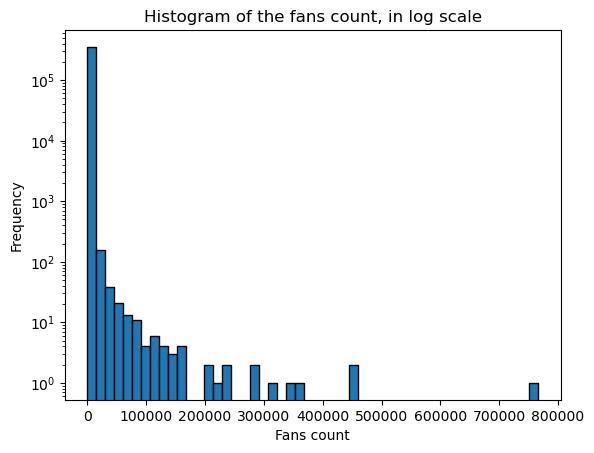

<Figure size 500x500 with 0 Axes>

In [129]:
# hist of the fans count of all the authors

plt.hist(authors.fans_count, bins=50, edgecolor='black')
plt.title('Histogram of the fans count, in log scale')
plt.xlabel('Fans count')
plt.ylabel('Frequency')
plt.yscale('log')
plt.figure(figsize=(5, 5))
plt.show()

In [130]:
print("The authors with 0 fans are", round(authors[authors["fans_count"] == 0].shape[0] / authors.shape[0], 4) * 100, "% of the total")
print("The authors less than 50 fans are", round(authors[authors["fans_count"] < 50].shape[0] / authors.shape[0], 4) * 100, "% of the total")
print("The authors more than 1000 fans are", round(authors[authors["fans_count"] > 1000].shape[0] / authors.shape[0], 4) * 100, "% of the total")

The authors with 0 fans are 23.41 % of the total
The authors less than 50 fans are 85.25 % of the total
The authors more than 1000 fans are 1.32 % of the total


We had to use logarithmic scale because there is a great variance between fans count across all authors in the dataset. We can see that only a very low number of authors has a great following and a quartes has no fans at all.

**We now have a look at ratings_count:**

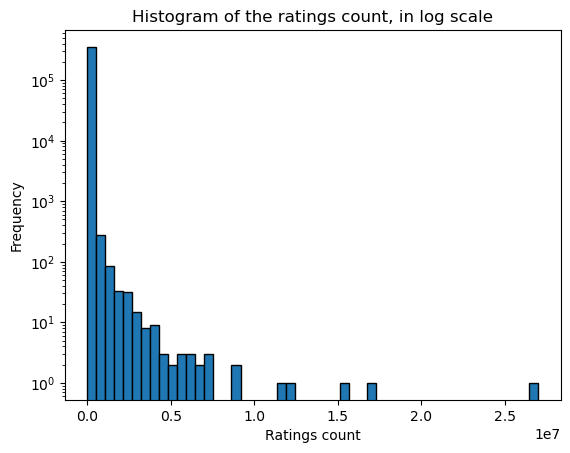

<Figure size 500x500 with 0 Axes>

In [131]:
# hist of the ratings count of all the authors
plt.hist(authors.ratings_count, bins=50, edgecolor='black')
plt.title('Histogram of the ratings count, in log scale')
plt.xlabel('Ratings count')
plt.ylabel('Frequency')
plt.yscale('log')
plt.figure(figsize=(5, 5))
plt.show()

In [132]:
print("Correlation between fans_count and ratings_count is", authors["fans_count"].corr(authors["ratings_count"]))

Correlation between fans_count and ratings_count is 0.580568202505027


The plot is very similar to the previous one (we had to use log scale here too), we can see a correlation between the number of fans and the number of ratings.

**We now have a look at text reviews count, expecting a similar behaviour:**

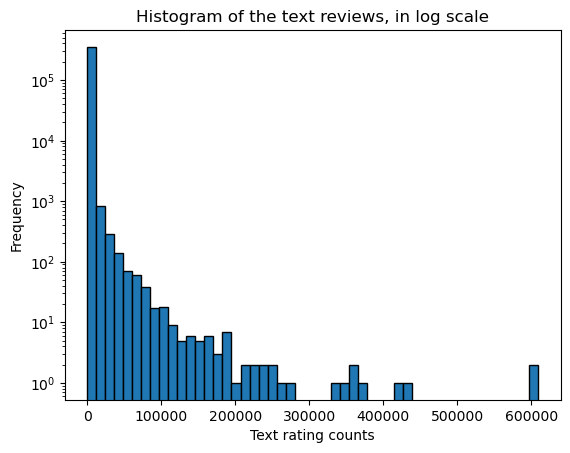

<Figure size 500x500 with 0 Axes>

In [133]:
#hist of the text reviews of all the authors
plt.hist(authors.text_reviews_count, bins=50, edgecolor='black')
plt.xlabel('Text rating counts')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of the text reviews, in log scale')
plt.figure(figsize=(5, 5))
plt.show()

In [134]:
print("Correlation between fans_count and ratings_count is", authors["fans_count"].corr(authors["text_reviews_count"]))
print("The authors with with less than 53 text reviews are", round(authors[authors["text_reviews_count"] < 53].shape[0] / authors.shape[0], 4) * 100, "% of the total")

Correlation between fans_count and ratings_count is 0.6942710321914839
The authors with with less than 53 text reviews are 74.98 % of the total


The behaviour is indeed similar and the correlation value between text_reviews_count and fans_count is even higher. In particular we observe than the third quartile is at only 53 reviews while the max is above 600.000.

**We now have a look at average rating:**

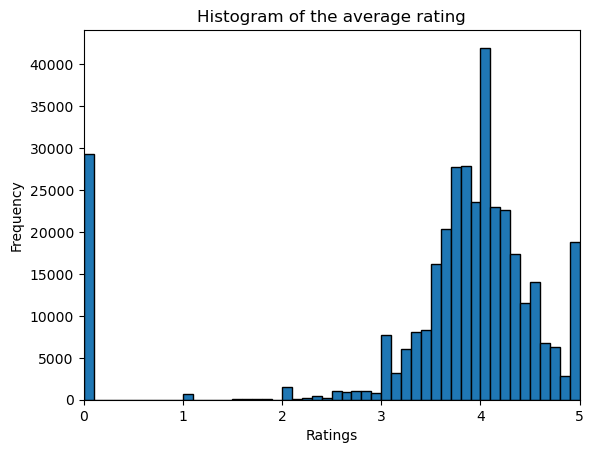

<Figure size 500x500 with 0 Axes>

In [135]:
# hist of the average ratings of all the authors
plt.hist(authors.average_rating, bins=50, edgecolor='black')
plt.xlim(0,5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of the average rating')
plt.figure(figsize=(5, 5))
plt.show()

The distribution seems to be a normal curve centered in 4. It's evident that integer values are more common than decimal one, as bins who comprend those tends to be higher, in particular for the average rating of zero.

In [136]:
authors[(authors["average_rating"] == 0) & (authors["ratings_count"] != 0)]

,ratings_count,average_rating,text_reviews_count,book_ids,name,gender,fans_count
id,,,,,,,


We can see that every author with a average rating of zero has no reviews. This means that the mean average rating we computed before is not entirely correct. A better estimate of the mean average rating is:

In [192]:
authors[authors["ratings_count"] != 0]["average_rating"].mean()

3.9834194136694663

**We now have a look at the number of books published by author.**

We previously removed the column because it had wrong values, we now may want to create a new one with correct values.

In [36]:
authors["books_count"] = authors["book_ids"].apply(len)

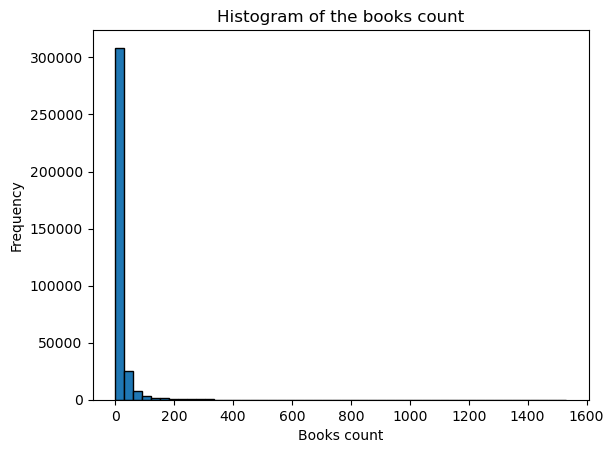

<Figure size 500x500 with 0 Axes>

In [37]:
# hist of the books count of all the authors

plt.hist(authors.books_count, bins=50, edgecolor='black')
plt.xlabel('Books count')
plt.ylabel('Frequency')
plt.title('Histogram of the books count')
plt.figure(figsize=(5, 5))
plt.show()

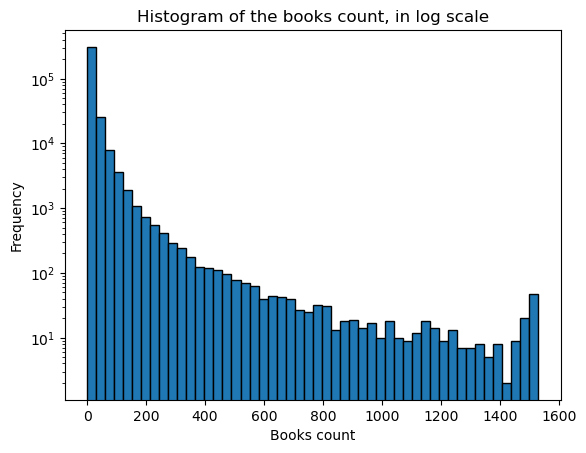

<Figure size 500x500 with 0 Axes>

In [38]:
# hist of the books count of all the authors, in log scale

plt.hist(authors.books_count, bins=50, edgecolor='black')
plt.xlabel('Books count')
plt.yscale('log')
plt.ylabel('Frequency')
plt.title('Histogram of the books count, in log scale')
plt.figure(figsize=(5, 5))
plt.show()

In [39]:
authors["books_count"].describe()

count    351740.000000
mean         17.417905
std          53.324583
min           0.000000
25%           2.000000
50%           6.000000
75%          15.000000
max        1530.000000
Name: books_count, dtype: float64

The number of books tends to be low, we see that the third quartile of the distribution is just at 15 books published but the max value is 1530. From the log scale plot we can see that values from between those two endpoints are present as well.

**We now have a look at the gender column:**

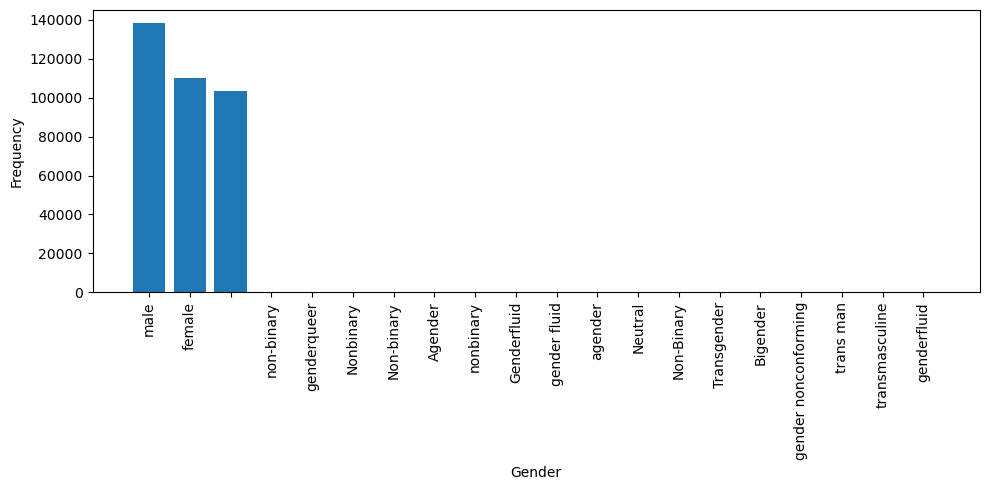

In [40]:
plt.figure(figsize=(10, 5))
plot_languages = authors['gender'].value_counts().head(20)
plt.bar(plot_languages.index, plot_languages.values)
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [41]:
percentage = round(authors[(authors["gender"] == "male") | (authors["gender"] == "female") | (authors["gender"] == "")].shape[0] / authors.shape[0], 4) * 100
print("Percentage of the first three results over the total is", percentage, "%")

Percentage of the first three results over the total is 99.91 %


Almost every author are either male, female or not specified.

**We now want to check for correlations.** We already found correlations between "ratings_count" and "fans_count" and between between "text_reviews_count" and "fans_count". We now plot a correlation matrix to check if there are others correlation we did not found earlier.

In [42]:
authors[["ratings_count", "average_rating", "text_reviews_count", "fans_count"]].corr()

,ratings_count,average_rating,text_reviews_count,fans_count
ratings_count,1.000000,0.015256,0.867628,0.580568
average_rating,0.015256,1.000000,0.024657,0.012479
text_reviews_count,0.867628,0.024657,1.000000,0.694271
fans_count,0.580568,0.012479,0.694271,1.000000


There is a strong correlation between "ratings_count" and "text_reviews_count", that is to be expected given that both easily correlates with the popularity of the author's books. We plot those correlation we haven't check before.

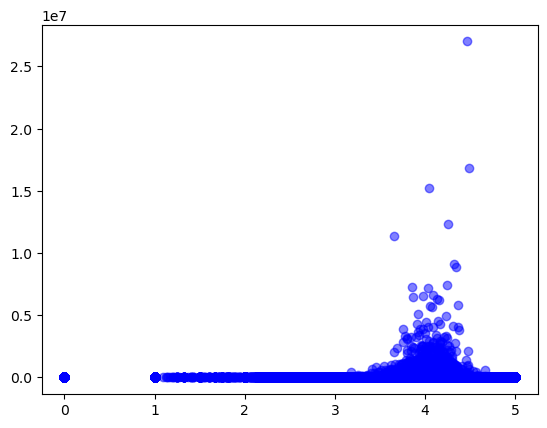

In [43]:
plt.scatter(authors['average_rating'], authors['ratings_count'], color='blue', marker='o', alpha=0.5)
plt.show()

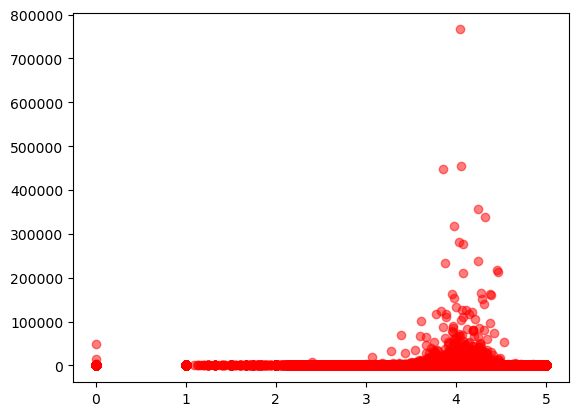

In [44]:
plt.scatter(authors.average_rating, authors.fans_count, color='red', marker='o', alpha=0.5)
plt.show()

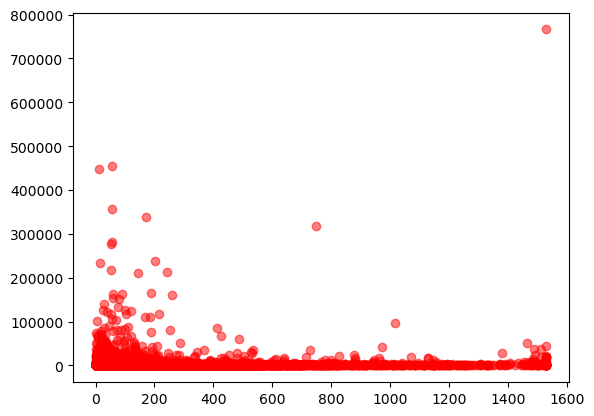

In [45]:
plt.scatter(authors.books_count, authors.fans_count, color='red', marker='o', alpha=0.5)
plt.show()

### Analize books

In [46]:
books.describe()

,author_id,average_rating,ratings_count,text_reviews_count
count,7.027431e+06,7.027431e+06,7.027431e+06,7.027431e+06
mean,1.977793e+06,3.306188e+00,1.945861e+04,6.417258e+02
std,3.210660e+06,1.435734e+00,1.609008e+05,4.169806e+03
min,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.368200e+04,3.360000e+00,3.000000e+00,0.000000e+00
50%,2.499460e+05,3.810000e+00,4.500000e+01,5.000000e+00
75%,3.239281e+06,4.080000e+00,7.710000e+02,6.400000e+01
max,2.124802e+07,5.000000e+00,7.400639e+06,1.745240e+05


It's interesting to observe that those negative "ratings_count" and "average_rating" values are not present in the books dataset. Also we note that the column "num_pages" that should be represented as numeric values is not present here. That is because during the dataset loading Pandas encountered some value that could not be translated to a numeric value and had to change the column to string. We'll se that later when we check that column.

Since the request of RQ 2.4 is to do an analysis of the "language" column we don't do that here to avoid repetitions.

**We now focus on the average rating, ratings count and text reviews count columns and check if there are the same correlations we have seen in the authors dataset:**

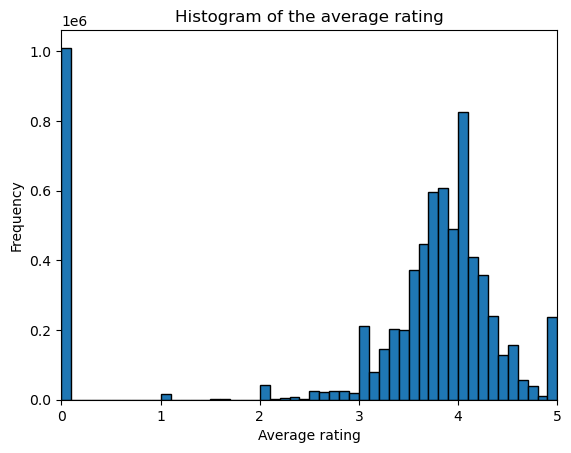

<Figure size 500x500 with 0 Axes>

In [47]:
plt.hist(books.average_rating, bins=50, edgecolor='black')
plt.xlim(0,5)
plt.xlabel('Average rating')
plt.ylabel('Frequency')
plt.title('Histogram of the average rating')
plt.figure(figsize=(5, 5))
plt.show()

The plot is very similar to the one viewed in the authors, the distribution remembers a Gaussian centered on 4 and there are peaks on the bins that contains integer vallues. Now for the ratings count:

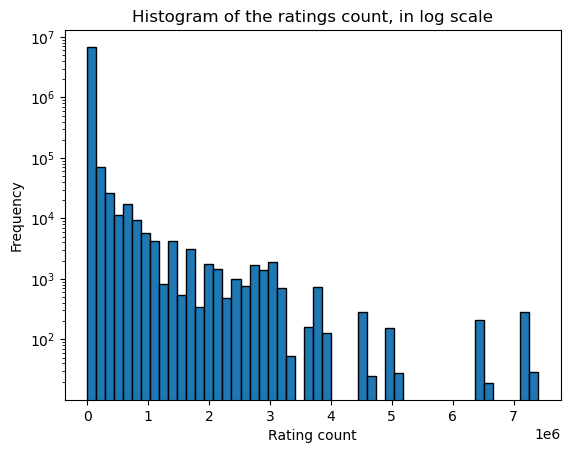

<Figure size 500x500 with 0 Axes>

In [48]:
plt.hist(books.ratings_count, bins=50, edgecolor='black')
plt.xlabel('Rating count')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of the ratings count, in log scale')
plt.figure(figsize=(5, 5))
plt.show()

In [49]:
books[(books["average_rating"] == 0) & (books["ratings_count"] != 0)]

,title,authors,author_name,author_id,language,average_rating,rating_dist,ratings_count,text_reviews_count,publication_date,original_publication_date,format,num_pages,series_id,series_name,series_position
id,,,,,,,,,,,,,,,,


As before an average rating of zero means no reviews. Also as before a better estimate of the mean average rating is:

In [50]:
books[books["ratings_count"] != 0]["average_rating"].mean()

3.8612964156464717

And now we plot the text reviews count:

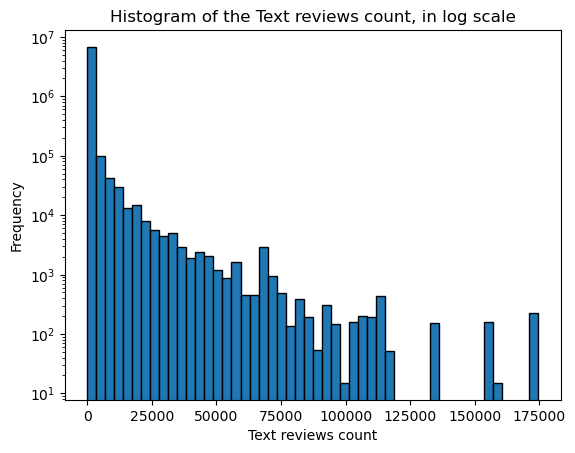

<Figure size 500x500 with 0 Axes>

In [196]:
plt.hist(books.text_reviews_count, bins=50, edgecolor='black')
plt.xlabel('Text reviews count')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of the Text reviews count, in log scale')
plt.figure(figsize=(5, 5))
plt.show()

And finally we calcuate the correlations between ratings count and text reviews count, that we expect to be very high.

In [51]:
books["ratings_count"].corr(books["text_reviews_count"])

0.9048858714171693

**We now focus on the format column:**

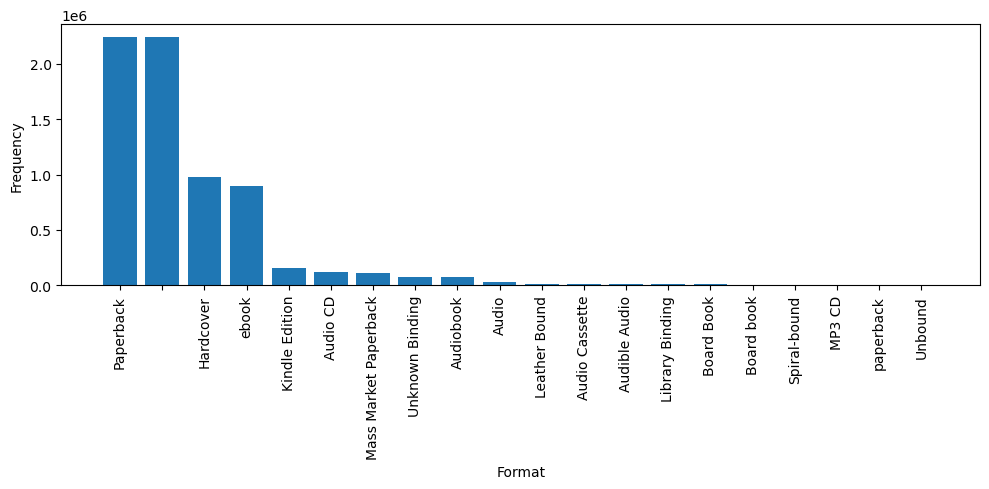

In [52]:
plt.figure(figsize=(10, 5))
plot_languages = books['format'].value_counts().head(20)
plt.bar(plot_languages.index, plot_languages.values)
plt.xlabel('Format')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [53]:
print("Books without a specified format are", round(books[books["format"] == ""].shape[0] / books.shape[0], 2) * 100, "% of the total.")

Books without a specified format are 32.0 % of the total.


**We now focus on the number of pages:**

In [54]:
print("There are", books[books["num_pages"] == ""].shape[0], "books with no page number.")
print("That's", round(books[books["num_pages"] == ""].shape[0] / books.shape[0], 4) * 100, "% of the whole dataset.")

There are 3071835 books with no page number.
That's 43.71 % of the whole dataset.


The column "num_pages" should contains integers but is instead memorized as string. This is because some values in the dataset are void strings. The percentage of books that have no page number is very high, we cant just drop those columns. We keep the column as it is and when a future exercise require it we just "focus" on the books with a number of pages by selecting them.

In [55]:
only_num_pages = books[books["num_pages"] != ""]["num_pages"].astype(int)
only_num_pages.describe()

count    3.955596e+06
mean     3.049865e+03
std      2.327717e+06
min      0.000000e+00
25%      1.320000e+02
50%      2.320000e+02
75%      3.440000e+02
max      2.147484e+09
Name: num_pages, dtype: float64

In [56]:
print("There are", (only_num_pages == 0).sum(), "books with no pages")

There are 27409 books with no pages


We see mean and median are very different (3049 vs 232), they are one order of magnitude apart. That's because there are some very strong outliers.

Some books have strange values: lots of books have no pages and some books have exactly 2.147.483.647 pages. This value is the largest positive value a 32-bit signed integer can hold, so it's probably made by an error of some kind. Another strange value is a book with 1.409.131.432, this value is wrong too as that's the ISBN-10 of the book, not its number of pages. Other strange values we find are 1.000.000.000, 10.000.000 and lots of others.

To obtain a significative plot we decide to remove consider only books with less than 100.000 pages and than less than 1.000:

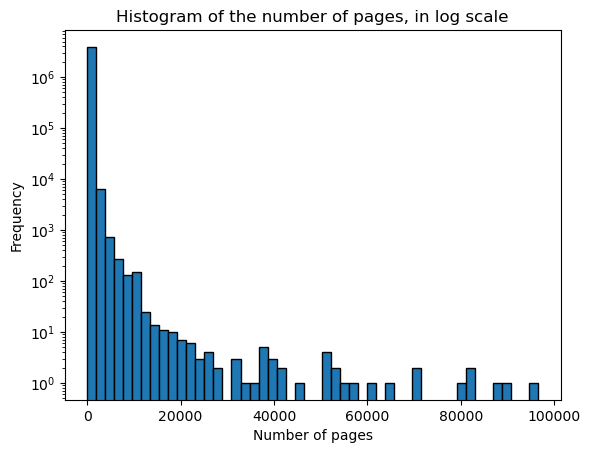

<Figure size 500x500 with 0 Axes>

In [57]:
plt.hist(only_num_pages[(only_num_pages != 0) & (only_num_pages < 100000)], bins=50, edgecolor='black')
plt.xlabel('Number of pages')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of the number of pages, in log scale')
plt.figure(figsize=(5, 5))
plt.show()

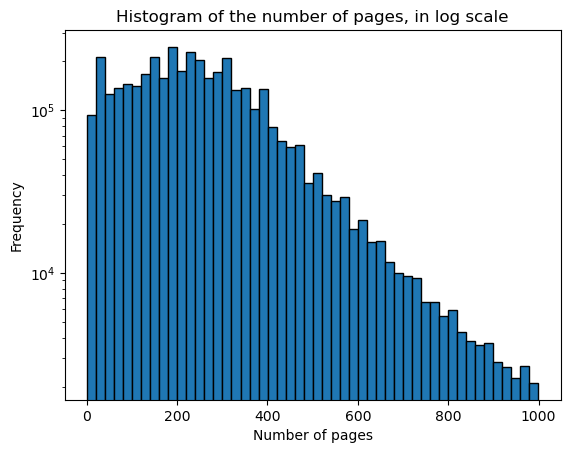

<Figure size 500x500 with 0 Axes>

In [58]:
plt.hist(only_num_pages[(only_num_pages != 0) & (only_num_pages < 1000)], bins=50, edgecolor='black')
plt.xlabel('Number of pages')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of the number of pages, in log scale')
plt.figure(figsize=(5, 5))
plt.show()

**We now focus on the publication date:**

Let's analyze for each book the publication date and the original publication date 

In [59]:
books[["publication_date", "original_publication_date"]].head(20)

,publication_date,original_publication_date
id,,
2,2004-09,2003-06-21
3,2003-11-01,1997-06-26
4,2003-11-01,1998-07-02
5,2004-05-01,1999-07-08
6,2002-09-28,2000-07-08
7,2006-09-01,2005-01-01
8,2004-09-13,2003-10-01
10,2005-09-12,2005-01-01
11,2005,1979-10-12


As we can see there are some books with no publication date and other that have only the year and even if we don't see them here there are some with invalid formats. We use a regex pattern to extract from those strings year and month, meanwhile the particular day has no use to us so we ignore it.

In [60]:
pattern = r"(-?[1-9][0-9]{3}|[1-9][0-9]{2}|[1-9][0-9]|[0-9])(?:-(0[1-9]|1[0-2]))?(?:-[0-2][0-9]|3[0-1])?"
dates = pd.DataFrame()
dates[["year", "month"]] = books["original_publication_date"].str.extract(pattern)

print(round(dates[dates["year"].isna()].shape[0] / books.shape[0], 4) * 100, "% of the dataset has not a valid original publication year")
print(round(dates[dates["month"].isna()].shape[0] / books.shape[0], 4) * 100, "% of the dataset has not a valid original publication month")

5.92 % of the dataset has not a valid original publication year
33.489999999999995 % of the dataset has not a valid original publication month


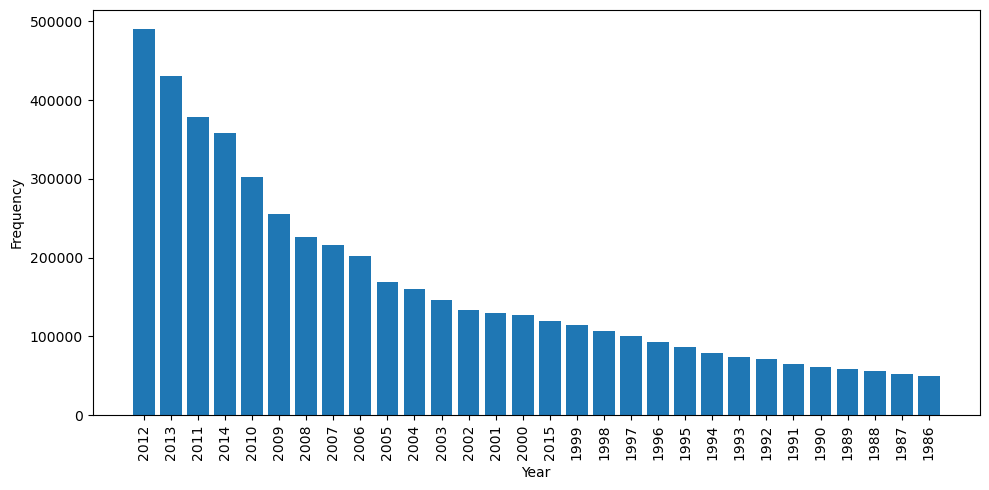

In [61]:
plt.figure(figsize=(10, 5))
plot_languages = dates['year'].value_counts().head(30)
plt.bar(plot_languages.index, plot_languages.values)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

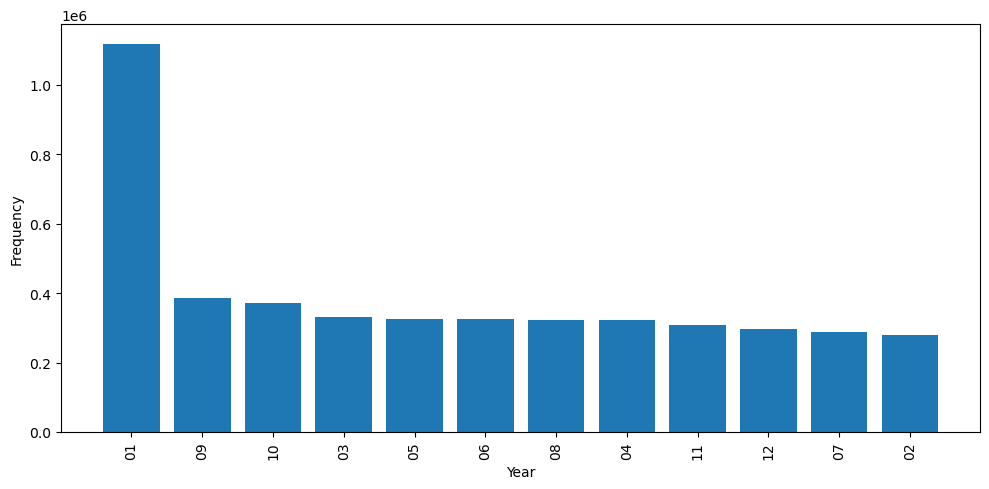

In [62]:
plt.figure(figsize=(10, 5))
plot_languages = dates['month'].value_counts()
plt.bar(plot_languages.index, plot_languages.values)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

A higher value on January is to be expected as January 1st is often a default value used when only the year is known.

In [63]:
dates = pd.DataFrame()
dates[["year", "month"]] = books["publication_date"].str.extract(pattern)

print(round(dates[dates["year"].isna()].shape[0] / books.shape[0], 4) * 100, "% of the dataset has not a valid publication year")
print(round(dates[dates["month"].isna()].shape[0] / books.shape[0], 4) * 100, "% of the dataset has not a valid publication month")

30.43 % of the dataset has not a valid publication year
41.75 % of the dataset has not a valid publication month


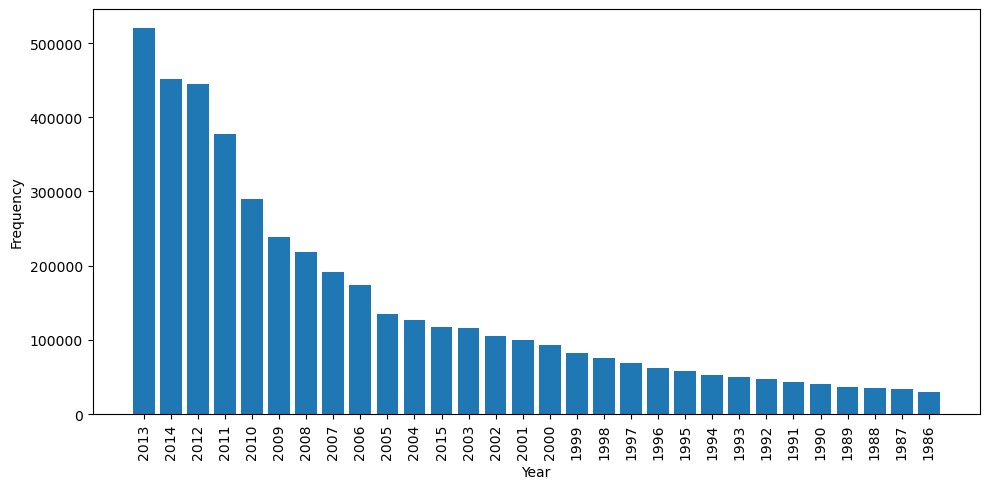

In [64]:
plt.figure(figsize=(10, 5))
plot_languages = dates['year'].value_counts().head(30)
plt.bar(plot_languages.index, plot_languages.values)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

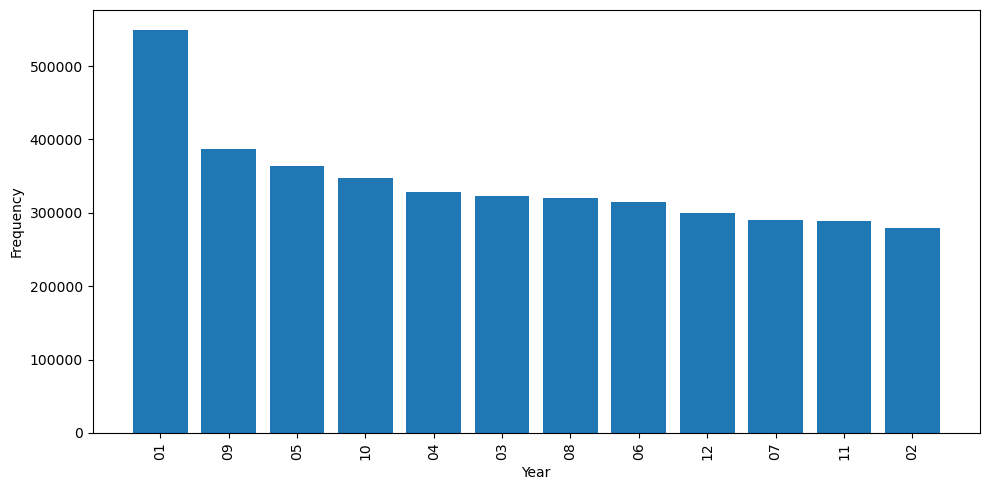

In [65]:
plt.figure(figsize=(10, 5))
plot_languages = dates['month'].value_counts()
plt.bar(plot_languages.index, plot_languages.values)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## [RQ2] Let’s finally dig into this vast dataset, retrieving some vital information:

**Request 2.1:** Plot the number of books for each author in descending order.

---

We decided to count the number of entries in the books dataset, meaning that every new edition or different format or the same book increase the count. For visibility reasons we limited the number of shown authors, to the top 100. The number of authors shown can be modified by changing the value of the parameter "n_authors".

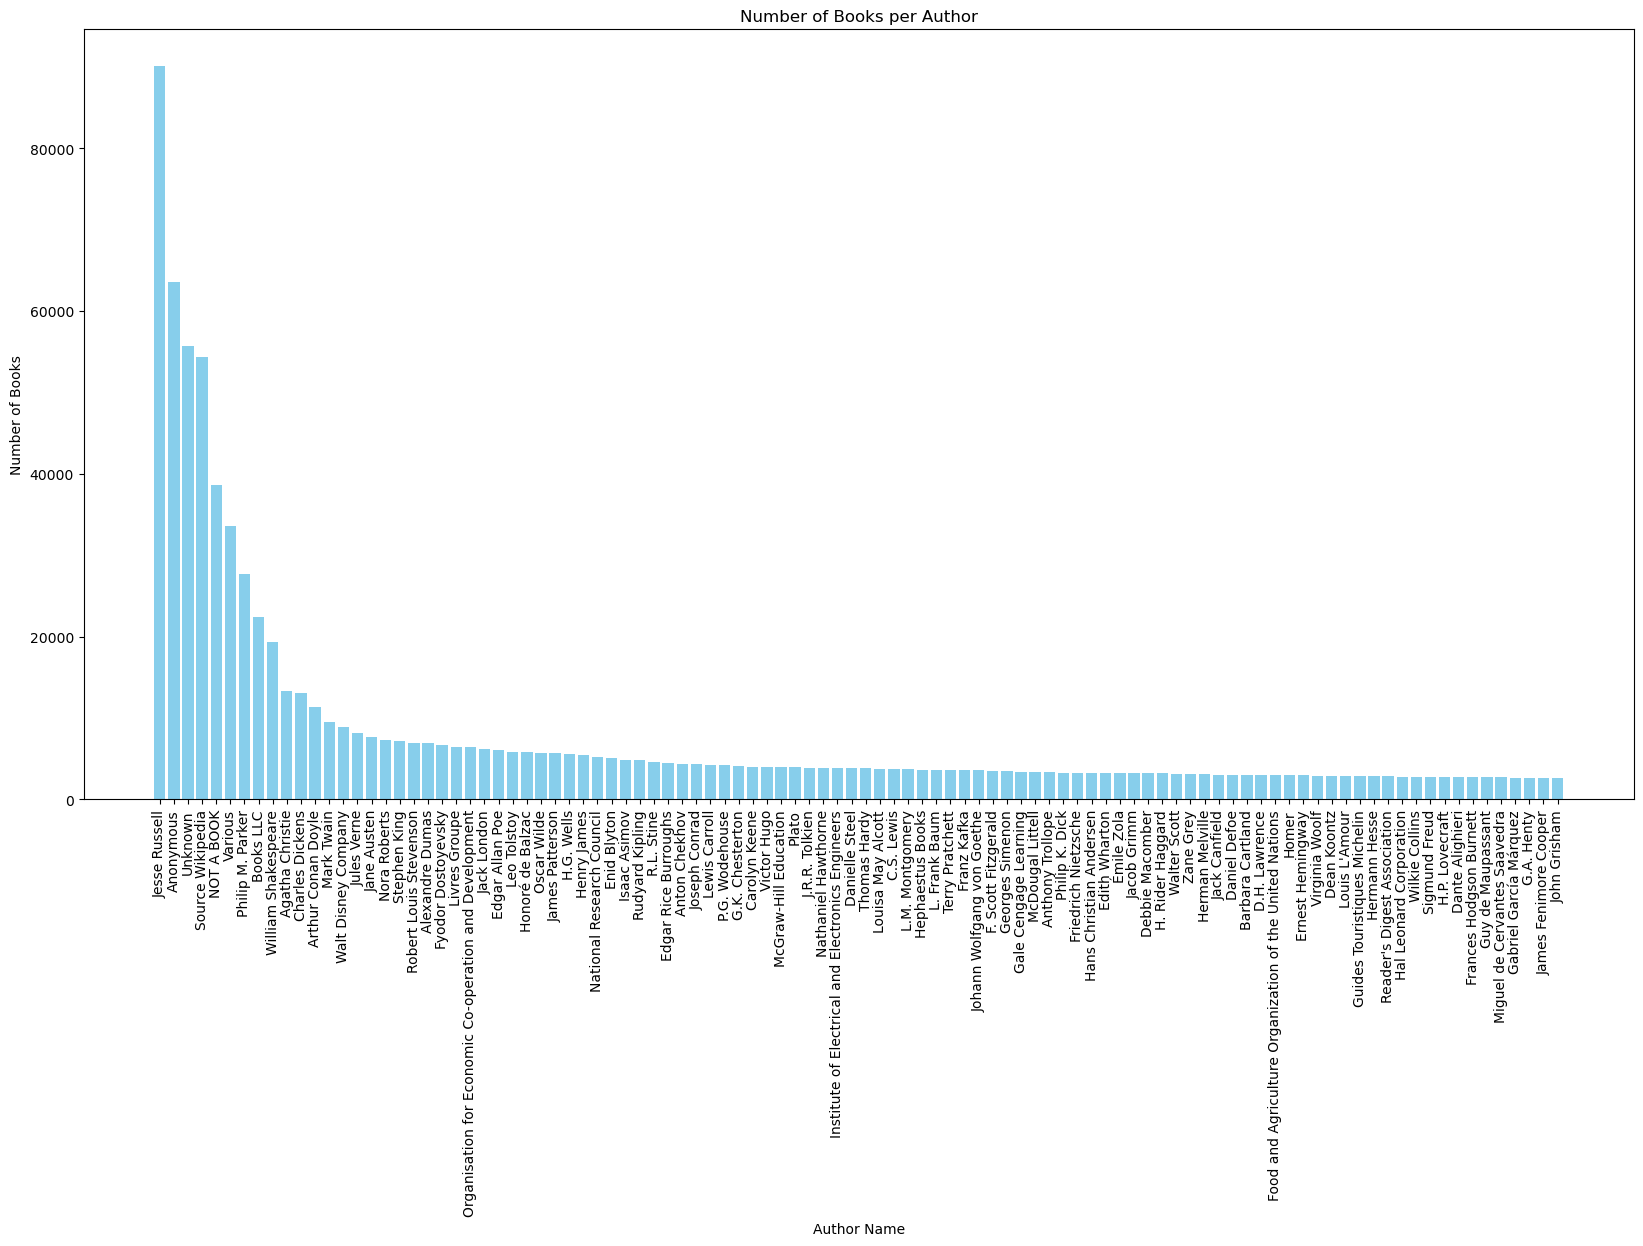

In [66]:
n_authors = 100
counts = books['author_name'].value_counts().sort_values(ascending = False).head(n_authors)

plt.figure(figsize=(20, 10))
plt.bar(counts.index, counts.values, color='skyblue')
plt.title('Number of Books per Author')
plt.xlabel('Author Name')
plt.ylabel('Number of Books')
plt.xticks(rotation=90)
plt.show()

Here we can see that lots of authors are placeholder names, like "Anonymous", "Unknown", "NOT A BOOK" or "Various", and others are not really authors but organizations or companies, such as "Source Wikipedia", "Books LLC", "Walt Disney Company" or "National Research Council".

**Request 2.2:**  Which book has the highest number of reviews?

---

We just execute a simple query over the books dataset.

In [67]:
books[books["text_reviews_count"] >= max(books["text_reviews_count"])]

,title,authors,author_name,author_id,language,average_rating,rating_dist,ratings_count,text_reviews_count,publication_date,original_publication_date,format,num_pages,series_id,series_name,series_position
id,,,,,,,,,,,,,,,,
19304768,"The Hunger Games (Hunger Games, #1)",None,Suzanne Collins,153394,en-US,4.32,5:3572190|4:1993815|3:772952|2:178537|1:97671|...,6615165,174524,,2008-09-14,,,73758,The Hunger Games,1


**Request 2.3:** Which are the top ten and ten worst books concerning the average score?

---

We execute a simple query on the books datasets.

In [68]:
books.nlargest(10, "average_rating")

,title,authors,author_name,author_id,language,average_rating,rating_dist,ratings_count,text_reviews_count,publication_date,original_publication_date,format,num_pages,series_id,series_name,series_position
id,,,,,,,,,,,,,,,,
238,Later Letters of Edward Lear to Chichester For...,None,Edward Lear,142,,5.0,5:4|4:0|3:0|2:0|1:0|total:4,4,2,,1907-01-01,,,,,
529,Lord of the Flies Activity Pack,None,James Scott,10685776,,5.0,5:1|4:0|3:0|2:0|1:0|total:1,1,0,,,,,,,
1045,Bernie Mac,None,Joanne Mattern,682,,5.0,5:2|4:0|3:0|2:0|1:0|total:2,2,0,2006-07-01,2006-07-31,Hardcover,32,,,
1072,Delaware 1638-1776 (Voices from Colonial America),"[{'id': '8305468', 'name': 'National Geographi...",National Geographic Kids,8305468,,5.0,5:1|4:0|3:0|2:0|1:0|total:1,1,0,2006-08-08,2006,Hardcover,112,256625,Voices from Colonial America,
1179,"Simply Italian: 100 Easy-To-Make, Zesty, Satis...","[{'id': '781', 'name': 'Ruth Glick', 'role': '...",Ruth Glick,781,,5.0,5:1|4:0|3:0|2:0|1:0|total:1,1,0,1999-03-31,1998,Paperback,161,,,
1272,Rudolph Giuliani,None,Wil Mara,847,,5.0,5:3|4:0|3:0|2:0|1:0|total:3,3,1,2003-09-01,2003-03,Paperback,32,,,
1748,"Singers, Heroes, and Gods in the Odyssey",None,Charles Segal,1161,,5.0,5:6|4:0|3:0|2:0|1:0|total:6,6,2,2010-10-05,1994-12-01,Paperback,264,,,
1773,Fanaroff and Martin's Neonatal-Perinatal Medic...,"[{'id': '327620', 'name': 'Avroy A. Fanaroff',...",Avroy A. Fanaroff,327620,,5.0,5:4|4:0|3:0|2:0|1:0|total:4,4,0,2005-09-01,2001-08-17,Hardcover,2036,,,
1975,A Den Of Thieves,None,Gretta Mulrooney,1331,,5.0,5:1|4:0|3:0|2:0|1:0|total:1,1,0,,1995,,,,,


In [69]:
books.nsmallest(10, "average_rating")

,title,authors,author_name,author_id,language,average_rating,rating_dist,ratings_count,text_reviews_count,publication_date,original_publication_date,format,num_pages,series_id,series_name,series_position
id,,,,,,,,,,,,,,,,
854,A More Perfect Way,None,Alex C. Jones,4429527,,0.0,5:0|4:0|3:0|2:0|1:0|total:0,0,0,2002-08-01,2002,Audio Cassette,,,,
855,Fields of Gold,None,Alex Jones,4098147,,0.0,5:0|4:0|3:0|2:0|1:0|total:0,0,0,2005-09-01,2005,Paperback,96,,,
860,Justitiemord: Fallet Keith Cederholm,None,Jan Guillou,260713,,0.0,5:0|4:0|3:0|2:0|1:0|total:0,0,0,,1983,,,,,
927,The Rain Falls Like Rain: Poems,None,David Helwig,613,,0.0,5:0|4:0|3:0|2:0|1:0|total:0,0,0,,1982,,204,,,
928,The Rain Falls Like Rain: Poems,None,David Helwig,613,,0.0,5:0|4:0|3:0|2:0|1:0|total:0,0,0,,1982,,,,,
1050,Riches in Real Estate: A Beginner's Guide to G...,None,Robert Irwin,6538881,,0.0,5:0|4:0|3:0|2:0|1:0|total:0,0,0,,1981,,,,,
1288,J.K.Lasser Pro Real Estate Investment Trusts: ...,None,Richard Imperiale,855,,0.0,5:0|4:0|3:0|2:0|1:0|total:0,0,0,2002-06-03,2002-06-15,Hardcover,372,,,
1302,Juiced Official Strategy Guide,None,Doug Walsh,86680,eng,0.0,5:0|4:0|3:0|2:0|1:0|total:0,0,0,2005-06-01,2005-06-01,Paperback,112,,,
1348,The Platonism of Marsilio Ficino: A Study of H...,None,Michael J.B. Allen,3970632,,0.0,5:0|4:0|3:0|2:0|1:0|total:0,0,0,1984-01-01,1984,Unknown Binding,284,,,


As we seen in the Exploratory Data Analysis there are lots of entries with rating 0.0 or 5.0 from them only 10 are taken and printed. As we can see observing the "id" they are also ordered by id. This could both mean that Pandas automatically choose "id" as a secondary ordering value or it took the first values it founds, as also in the source .json file entries are ordered by "id".

**Request 2.4:** Explore the different languages in the book’s dataset, providing a proper chart summarizing how these languages are distributed throughout our virtual library.

---

We firstly plot the distribution of all languages across the whole dataset. We use log scale for readibility reasons.

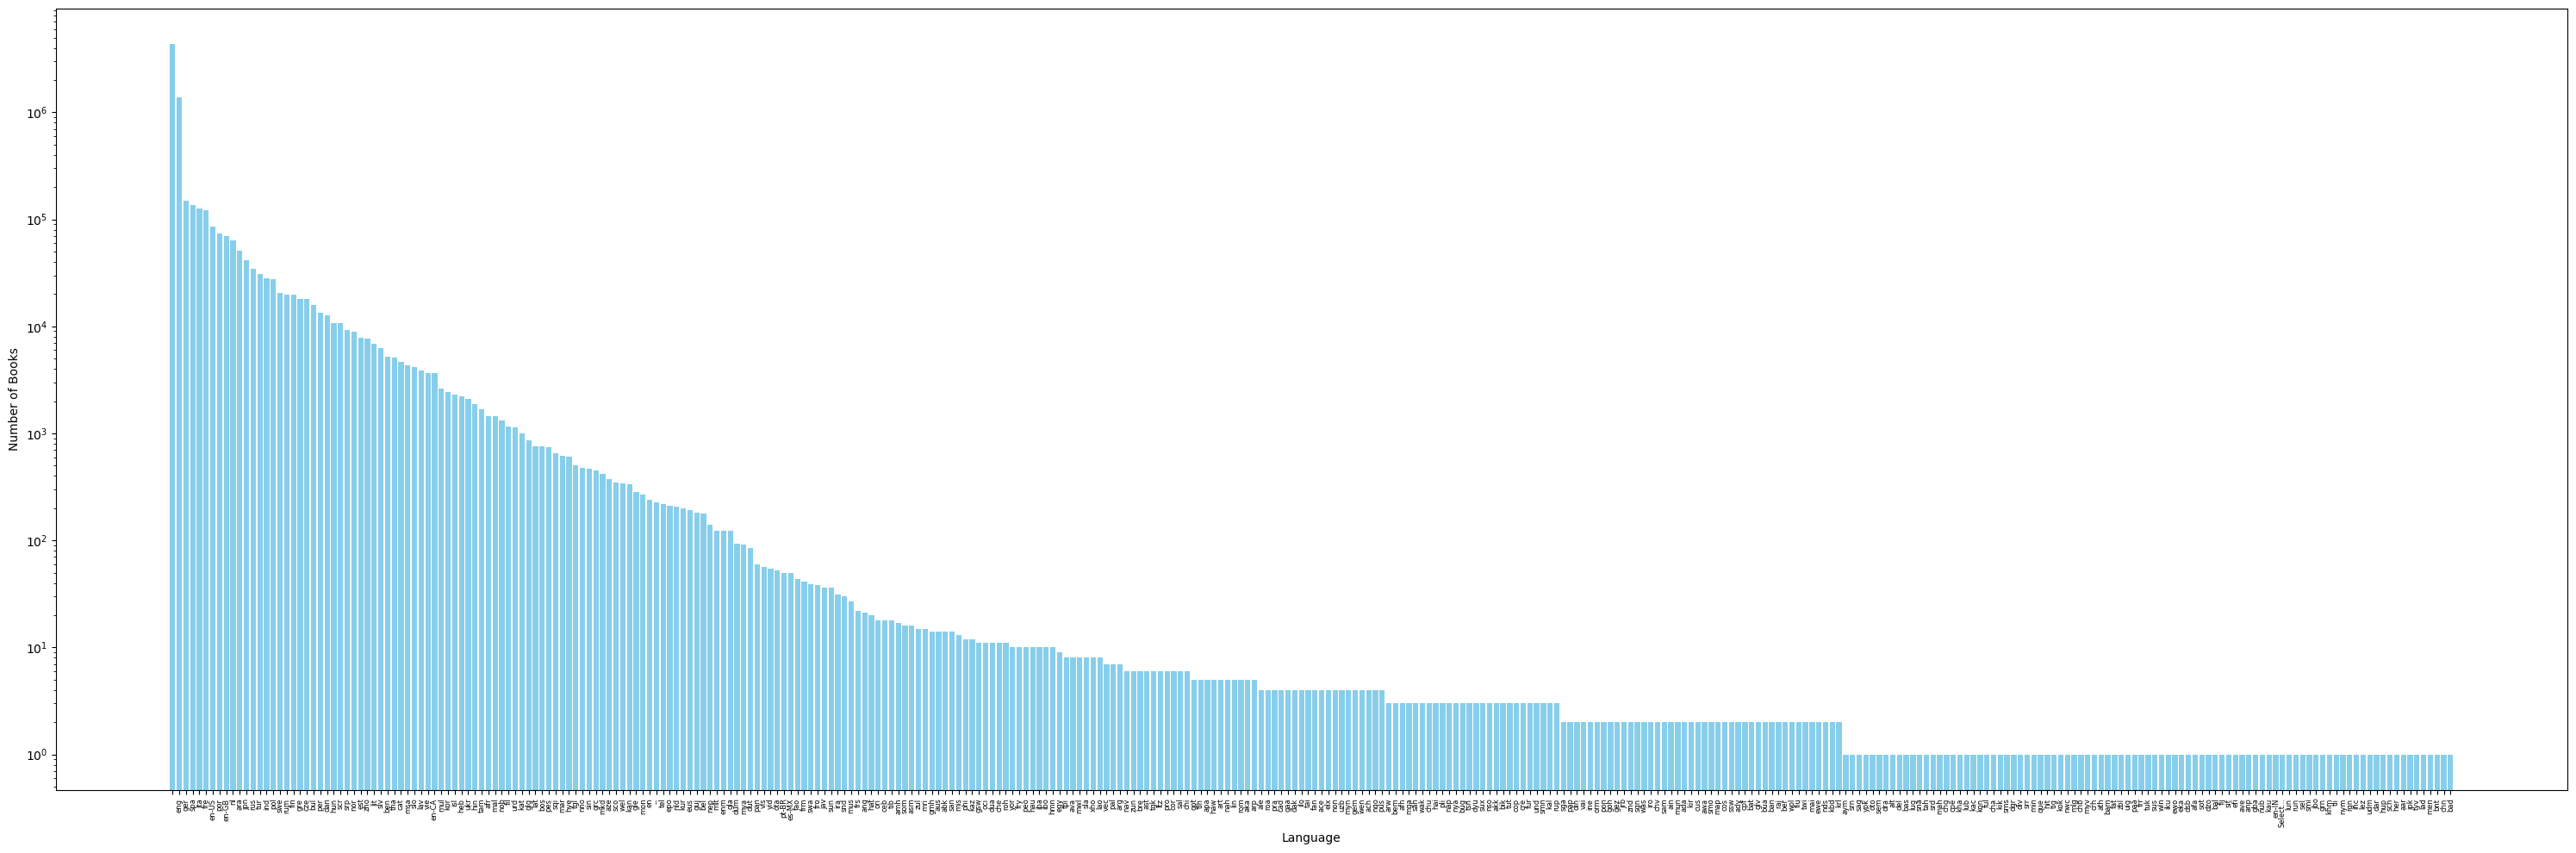

In [70]:
plt.figure(figsize=(30, 10))
plot_languages = books['language'].value_counts()
plt.bar(plot_languages.index, plot_languages.values, color='skyblue')
plt.xlabel('Language')
plt.ylabel('Number of Books')
plt.xticks(rotation=90)
plt.xticks(fontsize=6)
plt.yscale('log')
plt.tight_layout()
plt.show()

In [71]:
no_language = books[books["language"] == ""].shape[0]

print("The number of entries with an empty string as language is: ", no_language)
print("That's", round(no_language / books.shape[0], 2) * 100, "% of the whole dataset!")

The number of entries with an empty string as language is:  4340264
That's 62.0 % of the whole dataset!


Since empty strings are so common we decided to remove them from this plotting. We observe also other kinds of wrong values as "--" and "Select...". We also notice that a great amount of languages are present in only a single book and therefore decided to reduce the number of languages plotted for visibility porpuses. Also we merge different versions of the same language.

C:\Users\Utente\AppData\Local\Temp\ipykernel_8388\3480658789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  languages.replace(to_replace = ["en-US", "en-GB", "en-CA", "en"], value = "eng", inplace = True)
C:\Users\Utente\AppData\Local\Temp\ipykernel_8388\3480658789.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  languages.replace(to_replace = ["es-MX"], value = "es", inplace = True)
C:\Users\Utente\AppData\Local\Temp\ipykernel_8388\3480658789.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

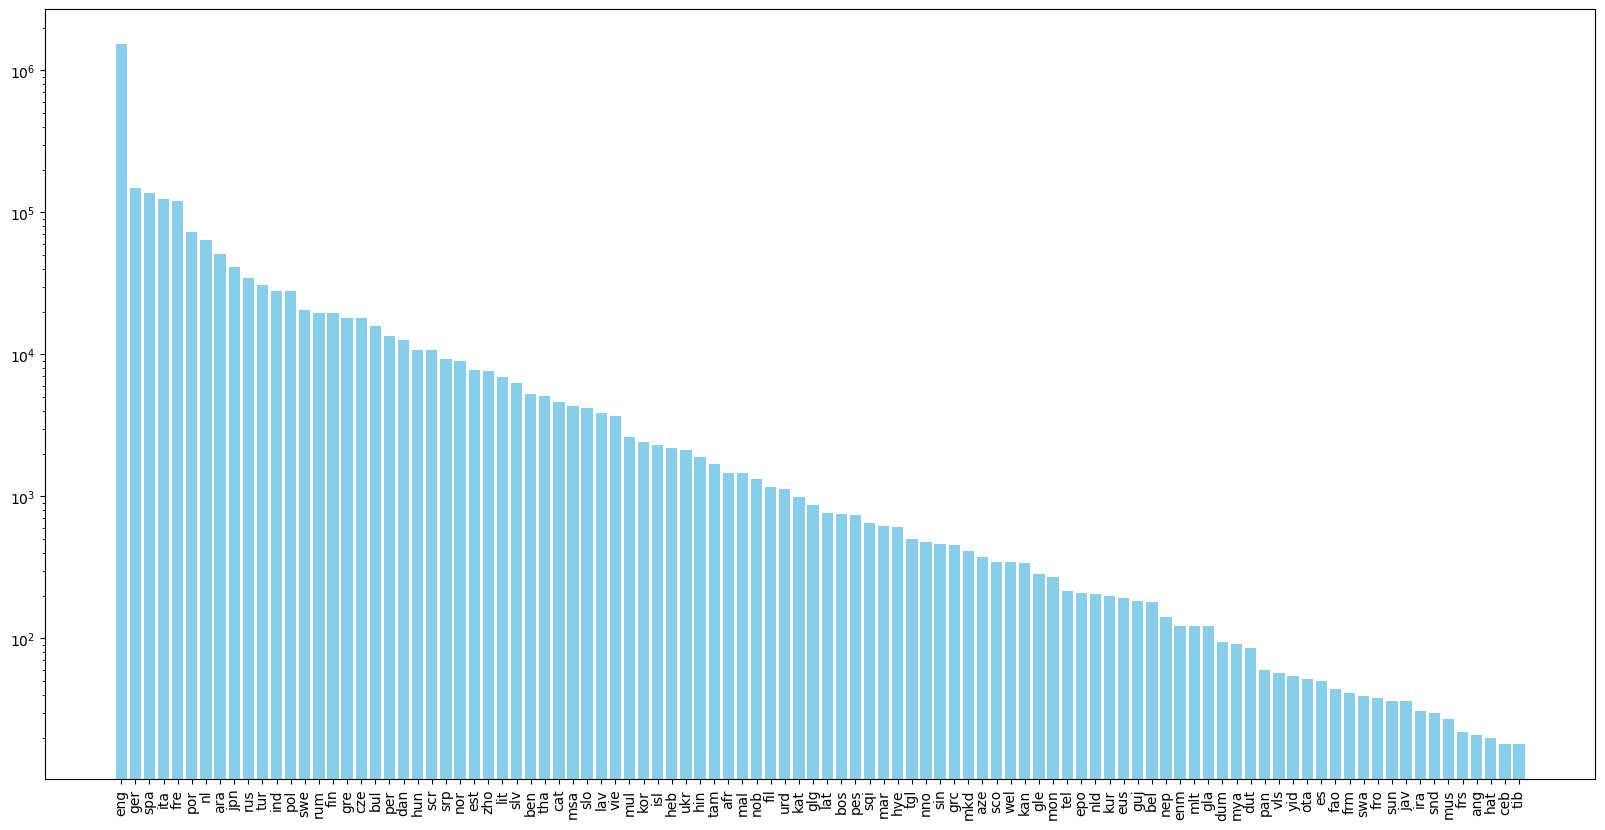

In [72]:
languages = books[(books["language"] != "") & (books["language"] != "--") & (books["language"] != "Select...")]
languages.replace(to_replace = ["en-US", "en-GB", "en-CA", "en"], value = "eng", inplace = True)
languages.replace(to_replace = ["es-MX"], value = "es", inplace = True)
languages.replace(to_replace = ["pt-BR"], value = "por", inplace = True)
plot_languages = languages['language'].value_counts().head(100)

plt.figure(figsize=(20, 10))
plt.bar(plot_languages.index, plot_languages.values, color='skyblue')
plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

In [73]:
print("The dataset contains", round(languages[languages["language"] == ("eng" or "en-US" or "en-GB" or "en-CA" or "en")].shape[0] / languages.shape[0], 4) * 100, "% english books.")
print("The dataset contains", round(languages[languages["language"] == ("ger")].shape[0] / languages.shape[0], 4) * 100, "% german books.")
print("The dataset contains", round(languages[languages["language"] == ("spa")].shape[0] / languages.shape[0], 4) * 100, "% spanish books.")
print("The dataset contains", round(languages[languages["language"] == ("ita")].shape[0] / languages.shape[0], 4) * 100, "% italian books.")

The dataset contains 57.010000000000005 % english books.
The dataset contains 5.510000000000001 % german books.
The dataset contains 5.11 % spanish books.
The dataset contains 4.66 % italian books.


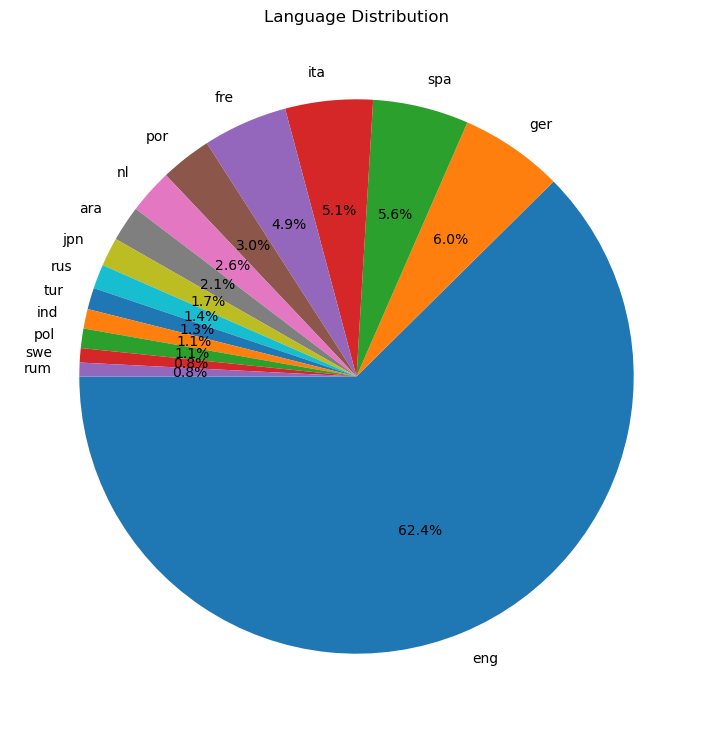

In [74]:
plot_languages = languages['language'].value_counts().head(15)
plt.figure(figsize=(9, 9))
plt.pie(plot_languages, labels=plot_languages.index, autopct='%1.1f%%', startangle=180)
plt.title('Language Distribution')
plt.show()

As we can see a large part of the dataset is made up of books written in English (we unified the different kinds of english, considering this significative as this will be also used in a following exercise.

**Request 2.5:** How many books have more than 250 pages?

---

As noticed that there are some entries that have a void string instead of the number of pages. For this query we discard them. However we decided to keep those strange values we have no way to know from which point those values start to be true, and the number of entries of those very values is limited.

In [75]:
# create a view that excludes the entries with void string
df = books[books["num_pages"] != ""]

# execute query
result = df[df["num_pages"].astype(int) > 250].shape[0]

print("There are", result, "books with more than 250 pages.")

There are 1810335 books with more than 250 pages.


**Request 2.6:** Plot the distribution of the fans count for the 50 most prolific authors (the ones who have written more books).

---

We use log scale for readibility reasons.

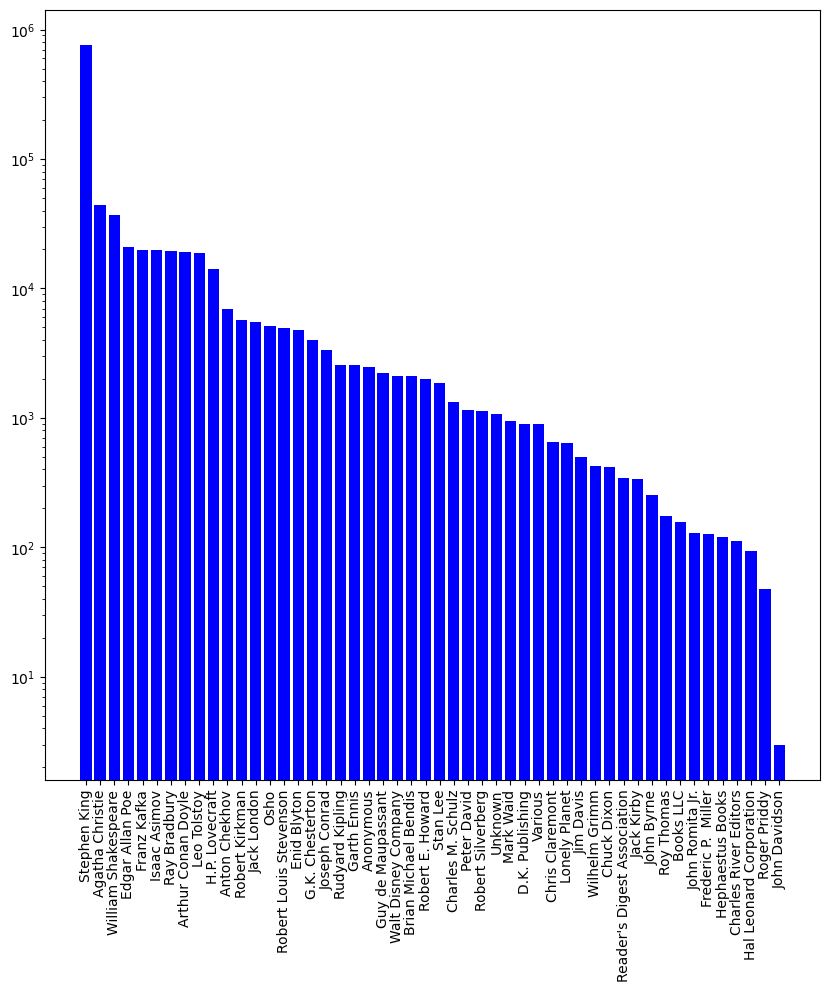

In [76]:
top_authors = authors.sort_values(by = "books_count", ascending = False).head(50)
top_authors.sort_values(by = "fans_count", inplace = True, ascending = False)
plt.figure(figsize=(10, 10))
plt.bar(top_authors["name"], top_authors["fans_count"], color='blue')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

As we have seen before there are some 'strange' values that are not really authors, but are placeholder names or companies. We try to remove them.

In [77]:
df = authors[(authors["name"] != "Walt Disney Company") & (authors["name"] != "Hal Leonard Corporation") & (authors["name"] != "Hephaestus Books") & (authors["name"] != "Charles River Editors") & (authors["name"] != "D.K. Publishing") & (authors["name"] != "Anonymous") & (authors["name"] != "Books LLC") & (authors["name"] != "Unknown") & (authors["name"] != "Various") & (authors["name"] != "Reader's Digest Association")]

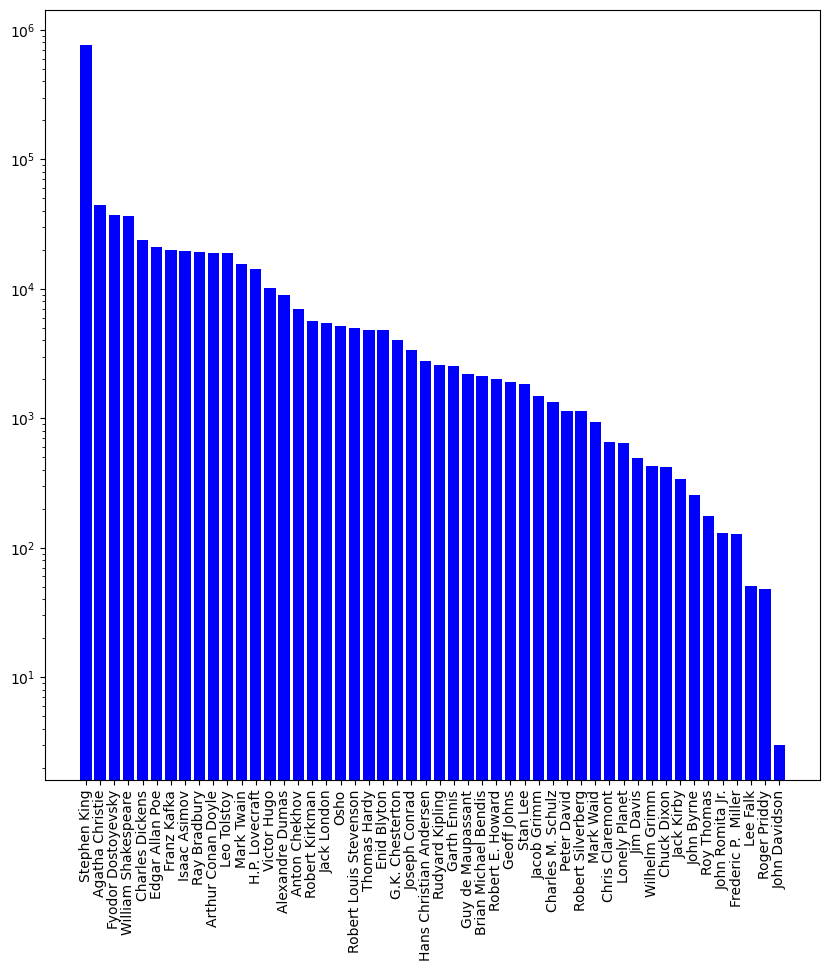

In [78]:
top_authors = df.sort_values(by = "books_count", ascending = False).head(50)
top_authors.sort_values(by = "fans_count", inplace = True, ascending = False)
plt.figure(figsize=(10, 10))
plt.bar(top_authors["name"], top_authors["fans_count"], color='blue')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

## [RQ3] Let’s have a historical look at the dataset!

**Request 3.1:** Write a function that takes as input a year and returns as output the following information:

* The number of books published that year.
* The total number of pages written that year.
* The most prolific month of that year.
* The longest book written that year.

In [79]:
# num pages cleaning
df = books[books["num_pages"] != ""]
df["num_pages"] = df["num_pages"].astype(int)

# date information gathering
pattern = r"(-?[1-9][0-9]{3}|[1-9][0-9]{2}|[1-9][0-9]|[0-9])(?:-(0[1-9]|1[0-2]))?(?:-[0-2][0-9]|3[0-1])?"
df[["year", "month"]] = df["publication_date"].str.extract(pattern)
df = df[~df["year"].isna()]

C:\Users\Utente\AppData\Local\Temp\ipykernel_8388\1632202042.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["num_pages"] = df["num_pages"].astype(int)
C:\Users\Utente\AppData\Local\Temp\ipykernel_8388\1632202042.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[["year", "month"]] = df["publication_date"].str.extract(pattern)
C:\Users\Utente\AppData\Local\Temp\ipykernel_8388\1632202042.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

We decided to ignore every book that has an invalid date format. We decided to also treat those years that have negative date (meaning BC), however for those dates (but not only for those) no month is given. Also some years for which month are used they are not always present. When they are present we for the calculation about the most prolific month we only use those books who specify the month, while when no month is specified we use the placeholder value "00".

In [80]:
def look_by_year(books, year):
    books_year = books[books["year"] == str(year)]

    n_books = books_year.shape[0]
    tot_pages = books_year["num_pages"].sum()
    longest_book = books_year[books_year["num_pages"] >= books_year["num_pages"].max()]["title"].head(1).item()

    try:
        prolific_month = books_year.groupby("month")["num_pages"].sum().idxmax()
    except ValueError as e:
        prolific_month = "00"

    return n_books, tot_pages, prolific_month, longest_book

# test the function with a random year

look_by_year(df, 2000)

(71732, 19679637, '01', 'Deutschland 1948 bis 1999 in 10 Bänden')

**Request 3.2:** Use this function to build your data frame: the primary key will be a year, and the required information will be the attributes within the row. Finally, show the head and the tail of this new data frame considering the first ten years registered and the last ten years.

In [85]:
per_year_dataset = pd.DataFrame()

for year in tqdm(df["year"].unique(), total = df["year"].unique().shape[0]):
    per_year_dataset = pd.concat([per_year_dataset, pd.DataFrame((year,) + look_by_year(df, year)).T])

per_year_dataset = per_year_dataset.rename(columns = {0: "year", 1: "num_books", 2: "tot_pages", 3: "prolific_month", 4: "longest_book"})
per_year_dataset = per_year_dataset.set_index("year")

  0%|          | 0/769 [00:00<?, ?it/s]

In [86]:
per_year_dataset.head(10)

,num_books,tot_pages,prolific_month,longest_book
year,,,,
2004,98484,27215883,01,21st Century Complete Medical Guide to Influen...
2003,90999,25332025,01,21st Century Complete Guide To The National Se...
2002,83862,23416999,01,"21st Century Complete Guide to the Gulf War, O..."
2005,107751,29636449,01,مجموعة الفتاوى
1996,48815,13072503,01,"The Oxford Mark Twain [29 Volumes, Signed] (Li..."
2001,76559,21264302,01,The Persian Encyclopedia (دايرة المعارف فارسى)
2000,71732,19679637,01,Deutschland 1948 bis 1999 in 10 Bänden
1990,32103,8540136,01,Dictionary of Drawing
1993,39596,10917638,01,Gyilkosság a paplakban


In [87]:
per_year_dataset.tail(10)

,num_books,tot_pages,prolific_month,longest_book
year,,,,
1458,1,26,00,Heidelberger Totentanz
1649,2,630,00,A Free Disputation Against Pretended Liberty o...
180,1,235,00,Den röda dvärgen
1617,1,48,00,The Bride
2915,1,181,03,Invisible Wounds
105,1,186,03,Anders Zorn: Unveiled
2550,1,488,00,"มนตรามหาภัย (Septimus Heap, #2)"
2051,1,376,06,7 dagen
1532,1,111,00,El Principe


**Request 3.3:** Ask ChatGPT or any other LLM chatbot tool to implement this function and compare your work with the one the bot gave you as an answer. Does the chatbot implementation work? Please test it out and verify the correctness of the implementation, explaining the process you followed to prove it.

---

We given ChatGPT the following prompt:

```
Given a book dataset in Pandas that has between it's values month and year of publication as columns "month" and "year" write a function that takes as input a year and returns as output the following information:

* The number of books published that year.
* The total number of pages written that year (the column for the number of pages is called "num_pages")
* The most prolific month of that year.
* The longest book written that year.

Mind that not every entry has a month value and when that happens you don't have to count that value towards the most prolific month answer. When no entry in for that year as a month value just fill the most prolific month value with "00". Mind also that while the "year" input of the function is an int the column "year" in the dataset is a string.
```

The answer of ChatGPT is the following prompt, from which we only modified the year of the example to make it equal as the one used above:

In [84]:
import pandas as pd

def get_yearly_stats(books_df, input_year):
    # Convert the input year to a string
    input_year = str(input_year)

    # Filter the DataFrame to include only entries for the specified year
    yearly_data = books_df[books_df['year'] == input_year]

    # Calculate the number of books published in that year
    num_books_published = len(yearly_data)

    # Calculate the total number of pages written in that year
    total_pages = yearly_data['num_pages'].sum()

    # Calculate the most prolific month of that year
    # First, filter out entries with month values and group by month
    monthly_data = yearly_data[yearly_data['month'].notna()]
    month_counts = monthly_data['month'].value_counts()
    
    # If there are no entries with month values, set the most prolific month to "00"
    if month_counts.empty:
        most_prolific_month = "00"
    else:
        most_prolific_month = month_counts.idxmax()

    # Find the longest book written in that year
    longest_book = yearly_data.loc[yearly_data['num_pages'].idxmax()]

    return {
        'num_books_published': num_books_published,
        'total_pages_written': total_pages,
        'most_prolific_month': most_prolific_month,
        'longest_book': longest_book
    }

# Example usage:
# Assuming 'df' is your Pandas DataFrame containing the book dataset
yearly_stats = get_yearly_stats(df, 2000)
print(yearly_stats)

{'num_books_published': 71732, 'total_pages_written': 19679637, 'most_prolific_month': '01', 'longest_book': title                        Deutschland 1948 bis 1999 in 10 Bänden
authors                                                        None
author_name                                                 Unknown
author_id                                                   4699102
language                                                        ger
average_rating                                                  3.0
rating_dist                             5:0|4:0|3:1|2:0|1:0|total:1
ratings_count                                                     1
text_reviews_count                                                0
publication_date                                               2000
original_publication_date                                2000-01-01
format                                                    Paperback
num_pages                                                     10236
series_

The answer is correct, with the only diffence that ChatGPT returned for the longest book the entire book entry while we returned only its title.

## [RQ4] Quirks questions about consistency. In most cases, we will not have a consistent dataset, and the one we are dealing with is no exception. So, let's enhance our analysis.

**Request 4.1:** You should be sure there are no eponymous (different authors who have precisely the same name) in the author's dataset. Is it true?

In [179]:
# check whether the entry is a duplicate or a different author
names = authors['name'].value_counts()
dupl_auth = names[names > 1]

print("Number of double entries: ", len(dupl_auth))

eponymous = []
duplicates = []

# iterate through the authors dataframe names, and if the same name matches 2 ids, append to eponymous, otherwise if singular id for both entries, append to duplicates

for i in range(len(dupl_auth.index)):
    auth_df = authors[authors['name'] == dupl_auth.index[i]]
    if len(list(set(auth_df['book_ids'].iloc[0] + auth_df['book_ids'].iloc[1]))) == len(auth_df['book_ids'].iloc[0]) + len(auth_df['book_ids'].iloc[1]):
        eponymous.append(dupl_auth.index[i])
    else:
        duplicates.append(dupl_auth.index[i])
    
print("The duplicate entries referring to the same authors are:\n", duplicates)
print("\n The actually eponymous authors are:\n", eponymous)


Number of double entries:  37
The duplicate entries referring to the same authors are:
 ['Chris Lynch', '小野不由美', 'Dimitar Dimov', 'Paul Graham', 'Cicerón', 'Jorge Molina', 'Robert W. Sullivan IV', 'James C.L. Carson', 'Mike   Lee', 'Hildegard von Bingen', 'Yordan Yovkov', 'William Messner-Loebs', 'John  Mole', 'Boris Zakhoder', 'James Kent', 'Peter      Marshall', 'George  Franklin', 'Peter Green', 'M.K. Graff', 'Joseph Fink', 'Martin    Shaw', 'محمد نجيب', 'Erin  Bedford', 'Peter King', 'Katherine Mercurio Gotthardt', 'Christopher Phillips', 'David Yates', 'Q. Hayashida', 'Jackson Butch Guice']

 The actually eponymous authors are:
 ['Peter    Green', 'Catherine   Jones', 'Peter  Davies', 'David  Nelson', 'Julie  Campbell', 'Peter  Marshall', 'Caroline Miller', 'Paul      Davies']


**Request 4.2:** Write a function that, given a list of author_id, outputs a dictionary where each author_id is a key, and the related value is a list with the names of all the books the author has written.

In [180]:
def author_works_dic(author_ids: list):
    auth_books = {i: None for i in author_ids}

    for i in author_ids:
        try:
            bks = authors[authors.index == i].iloc[0]["book_ids"] 
            ttls = list()
            for bk in bks:                   
                if books[books.index == int(bk)].shape[0] != 0: 
                    ttls.append(books[books.index == int(bk)].iloc[0]['title']) 
            auth_books[i] = ttls 
        except IndexError:
            print("No author with ID: ", i)
    return auth_books

# test
author_works_dic([4, 7])

{4: ["The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)",
  "The Ultimate Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1-5)",
  "The Restaurant at the End of the Universe (Hitchhiker's Guide to the Galaxy, #2)",
  "Life, the Universe and Everything (Hitchhiker's Guide to the Galaxy, #3)",
  "So Long, and Thanks for All the Fish (The Hitchhiker's Guide to the Galaxy, #4)",
  "Dirk Gently's Holistic Detective Agency (Dirk Gently, #1)",
  "Mostly Harmless (Hitchhiker's Guide to the Galaxy, #5)",
  'The Long Dark Tea-Time of the Soul (Dirk Gently, #2)',
  "The Hitchhiker's Guide to the Galaxy: A Trilogy in Four Parts",
  'The Salmon of Doubt (Dirk Gently, #3)',
  "Young Zaphod Plays It Safe (Hitchhiker's Guide to the Galaxy, #0.5)",
  'Last Chance to See',
  "The Hitch Hiker's Guide to the Galaxy: A Trilogy in Five Parts",
  'The Dirk Gently Omnibus (Dirk Gently, #1-2)',
  'The Deeper Meaning of Liff',
  "The More Than Complete Hitchhiker's

**Request 4.3:** What is the longest book title among the books of the top 20 authors regarding their average rating? Is it the longest book title overall?

In [181]:
top_20_rating_auth = authors.nlargest(20, "average_rating").index
top_20_rating_books = author_works_dic(top_20_rating_auth)

longest_title = ""

for i in top_20_rating_books.values():
    for title in i:
        if len(title) > len(longest_title):
            longest_title = title

print("The longest title is:", len(longest_title), "characters long and is")
print(longest_title)

longest_overall_title = books['title'].str.len().idxmax()
longest_overall_title = books[books.index == longest_overall_title]["title"].item()
print("\nThe longest overall title is:", len(longest_overall_title), "characters long and is")
print(longest_overall_title)

The longest title is: 160 characters long and is
Domestic Politics and Family Absence: The Correspondence (1588-1621) of Robert Sidney, First Earl of Leicester, and Barbara Gamage Sidney, Countess of Leicester

The longest overall title is: 255 characters long and is
The New England Primer Issued Prior to 1830: A Bibliographical Checklist for the More Easy Attaining the True Knowledge of This Book, Embellished with a Hundred Cuts and Now Revised, Greatly Improved and Arranged in Two Alaphabets; With Preface, Introd...


We notice that the title is cut at exaclty 255 characters, a value that makes us think together with the point at the end of the string that the title should be longer but has been cut.

**Request 4.4:** What is the shortest overall book title in the dataset? If you find something strange, provide a comment on what happened and an alternative answer.

In [89]:
min_len = books["title"].str.len().min()
result = books[books["title"].str.len() == min_len]

print("The min length is", min_len, "and there are", result.shape[0], "books with the min length.")
print("The couples id / title of the titles with smallest lenght are:")
print(result["title"])

The min length is 0 and there are 33 books with the min length.
The couples id / title of the titles with smallest lenght are:
id
7857246     
8065192     
8086737     
8569155     
9827732     
10192004    
10275196    
10580295    
10845712    
10845714    
10845715    
10862054    
11194836    
11251197    
11296214    
11436722    
11439071    
11442606    
11468492    
11474699    
11518986    
11518987    
12089760    
12193767    
12193769    
12197351    
12451733    
12649326    
12668478    
12668479    
12699543    
12812177    
12897948    
Name: title, dtype: object


We notice that there are a few books with empty string as their title. We decide to remove them to provide a better answer.

In [90]:
df = books[books["title"] != ""]

min_len = df["title"].str.len().min()
result = df[df["title"].str.len() == min_len]

print("The min length is", min_len, "and there are", result.shape[0], "books with the min length.")
print("The couples id / title of the titles with smallest lenght are:")
print(result["title"])

The min length is 1 and there are 665 books with the min length.
The couples id / title of the titles with smallest lenght are:
id
49595       a
52945       G
65006       Q
65008       Q
94034       Q
           ..
25445562    Q
25446783    X
25453966    B
25484953    C
25515267    ر
Name: title, Length: 665, dtype: object


Titles are now of lenght 1, we still haven't achieved some significant results.

## [RQ5] We can consider the authors with the most fans to be influential. Let’s have a deeper look.

**Request 5.1a:** Plot the top 10 most influential authors regarding their fan count and number of books.

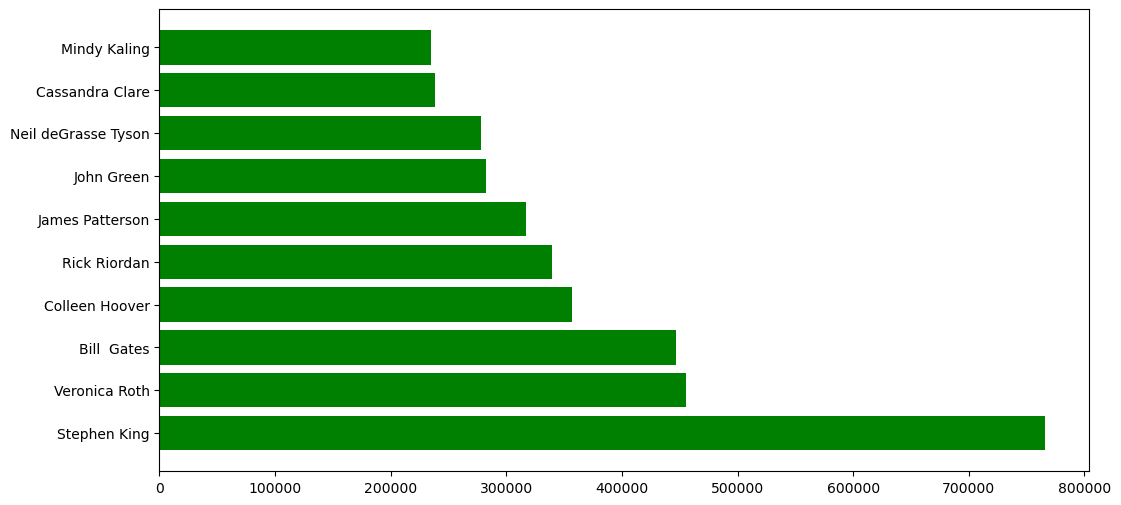

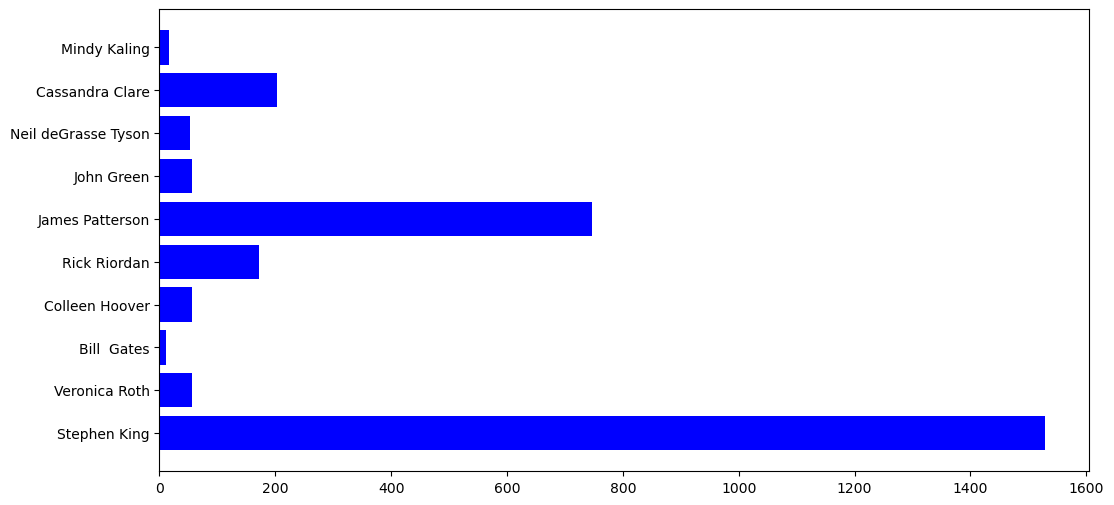

In [108]:
# 10 most influential authors regarding their fan count
x = authors.nlargest(10, "fans_count")

# plot the data
plt.figure(figsize=(12, 6))
plt.barh(x["name"], x["fans_count"], color = 'green', label = 'Fan Count')
plt.figure(figsize=(12, 6))
plt.barh(x["name"], x["books_count"], color = 'blue', label = 'Book Count')
plt.show()

**Request 5.1b:** Plot the top 10 most influential authors regarding their fan count and number of books. Who is the most influential author?

In [109]:
# most influential author
m_inf = authors.nlargest(1, "fans_count")
print("The most influential author, having by far the largest fanbase is:", m_inf["name"].item())

The most influential author, having by far the largest fanbase is: Stephen King


**Request 5.2:** Have they published any series of books? If any, extract the longest series name among these authors.

In [125]:
# create a new dataframe containing only the books written by the top 10 authors
top_authors_books = books[books["author_id"].isin(list(x.index))]

# get the series authors by their "series position" to find who has written series, and use max position to determine their longest series' length.
author_series_lengths = top_authors_books.groupby(["author_id", "author_name"])["series_position"].max().reset_index()

# return the highest series position, thus the longest series author and name
author_series = top_authors_books.groupby(["author_id", "author_name", "series_name"])["series_position"].max().reset_index()
max_series = author_series[author_series["series_position"] == author_series["series_position"].max()]

print("\nThe author of the longest series is:")
print(max_series["author_name"].to_string(index = False))
print("\nAnd the series is:")
print(max_series["series_name"].to_string(index = False))


The author of the longest series is:
Rick Riordan

And the series is:
Percy Jackson and the Olympians


**Request 5.3:** How many of these authors have been published in different formats? Provide a meaningful chart on the distribution of the formats and comment on it.

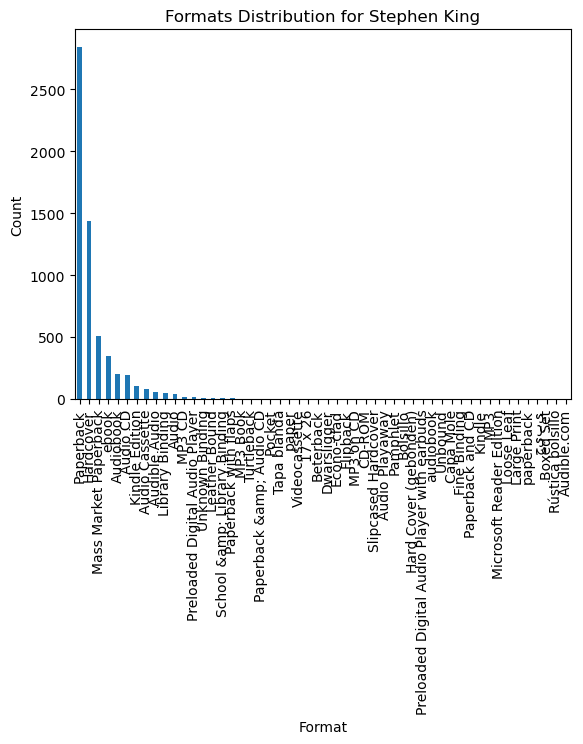

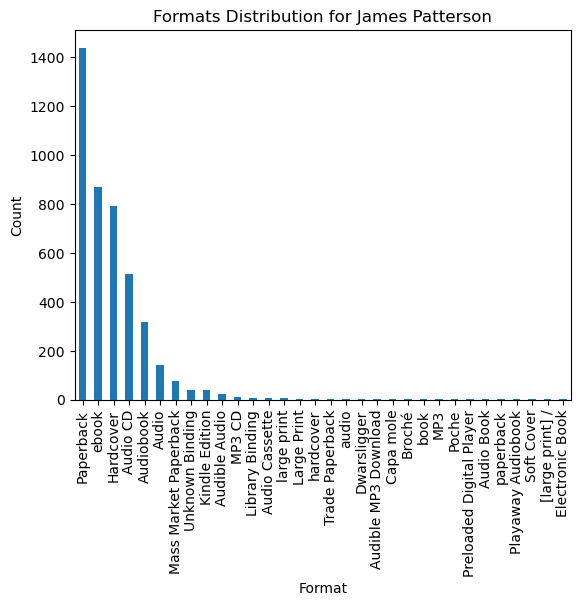

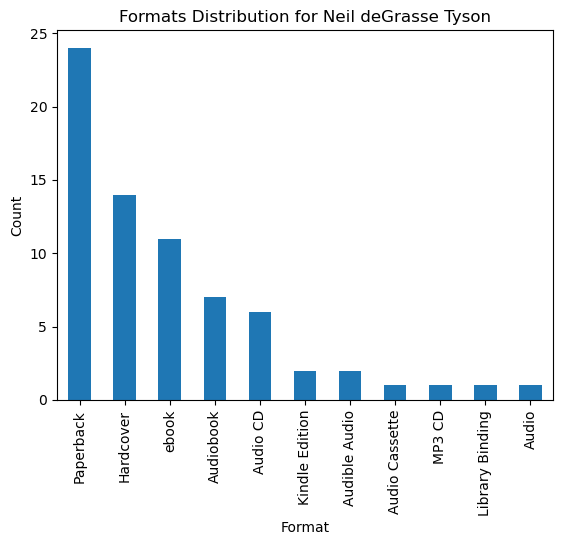

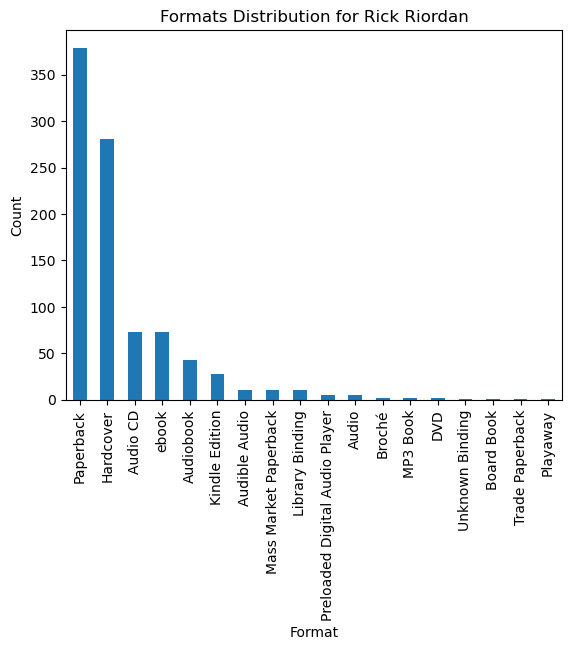

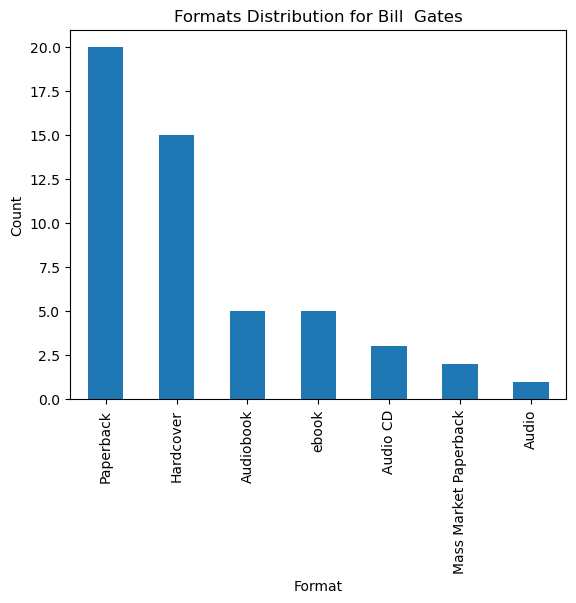

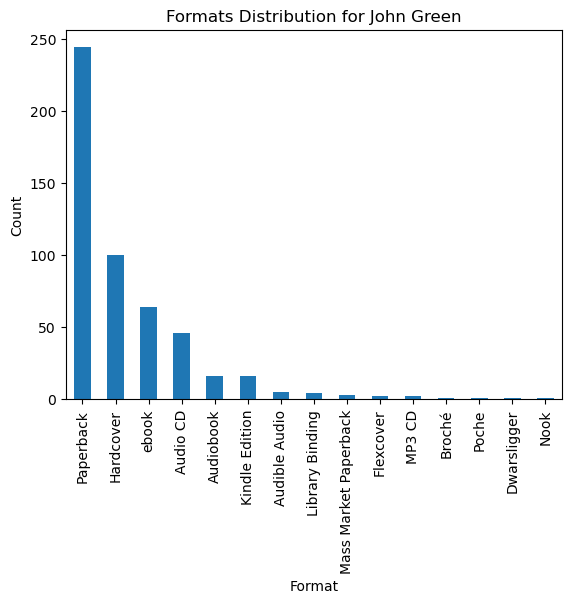

d:\Programs\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21109 (\N{CJK UNIFIED IDEOGRAPH-5275}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Programs\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Programs\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25512 (\N{CJK UNIFIED IDEOGRAPH-63A8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Programs\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29702 (\N{CJK UNIFIED IDEOGRAPH-7406}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Programs\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Program

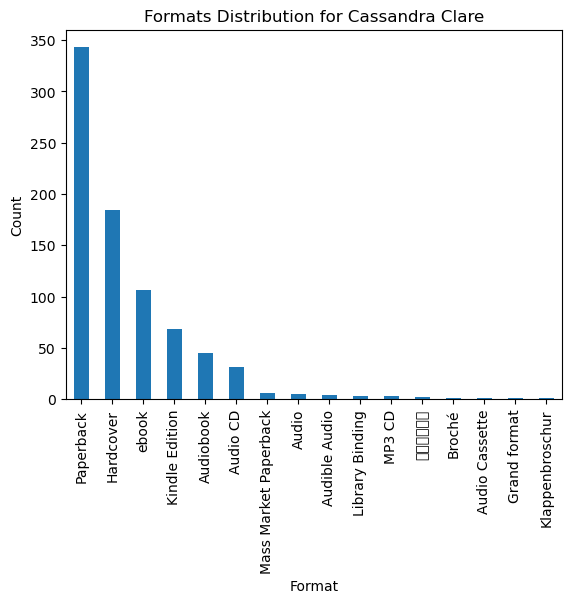

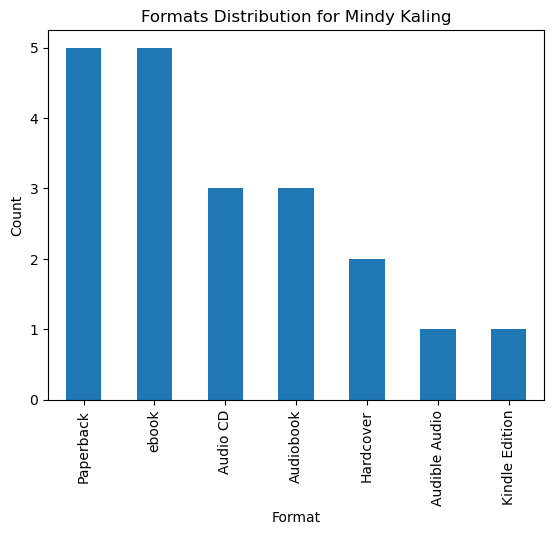

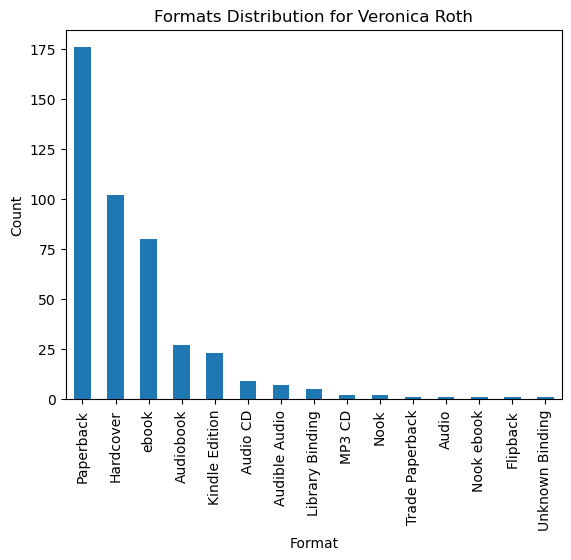

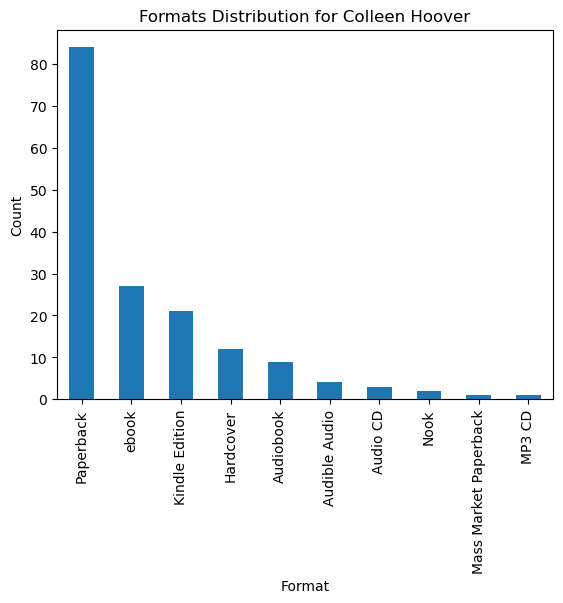

In [116]:
# to find the authors published in different formats from the top 10
authors_with_different_formats = top_authors_books[top_authors_books.duplicated(subset=["author_id"], keep = False)]
authors_with_different_formats = authors_with_different_formats[authors_with_different_formats["format"] != ""]

# to avoid name repetition
unique_author_ids = authors_with_different_formats["author_id"].unique()

# create a separate chart for each author with multiple formats
for author_id in unique_author_ids:
    author_data = authors_with_different_formats[authors_with_different_formats["author_id"] == author_id]
    author_name = author_data["author_name"].values[0]
    format_distribution = author_data["format"].value_counts()
    
    format_distribution.plot(kind='bar')
    plt.title(f"Formats Distribution for {author_name}")
    plt.xlabel("Format")
    plt.ylabel("Count")
    plt.show()

**Comments on the graphs above:** we can see that the books are mainly published in paperback and hardcover formats, whereas the "newer" digital formats are very few. This would be due to 3 main reasons:
1. The age of most of the books written by these authors, since audiobooks and ebook formats are relatively new.
2. Even with more widely available digital formats now, these are authors of novels and readers who usually enjoy leisurely reading prefer the physical format of paper, rather than reading through a screen.
3. Once a book has been published in a digital format, there is no need to republish it using another editorial, since it is already on the internet, a more universal "bookstore".

**Request 5.4:** Provide information about the general response from readers (number of fans, average rating, number of reviews, etc.), divide the authors by gender, and comment about anything eventually related to “structural bias.” You may want to have a look at the following recommended readings:

- https://bhm.scholasticahq.com/article/38021
- https://priyanka-ddit.medium.com/how-to-deal-with-imbalanced-dataset-86de86c49
- https://compass.onlinelibrary.wiley.com/doi/10.1111/soc4.12962

You can even ask ChatGPT or any other LLM chatbot tool: try to formulate a prompt that provides helpful information about it. Put that information in your notebook and provide comments on what you found.

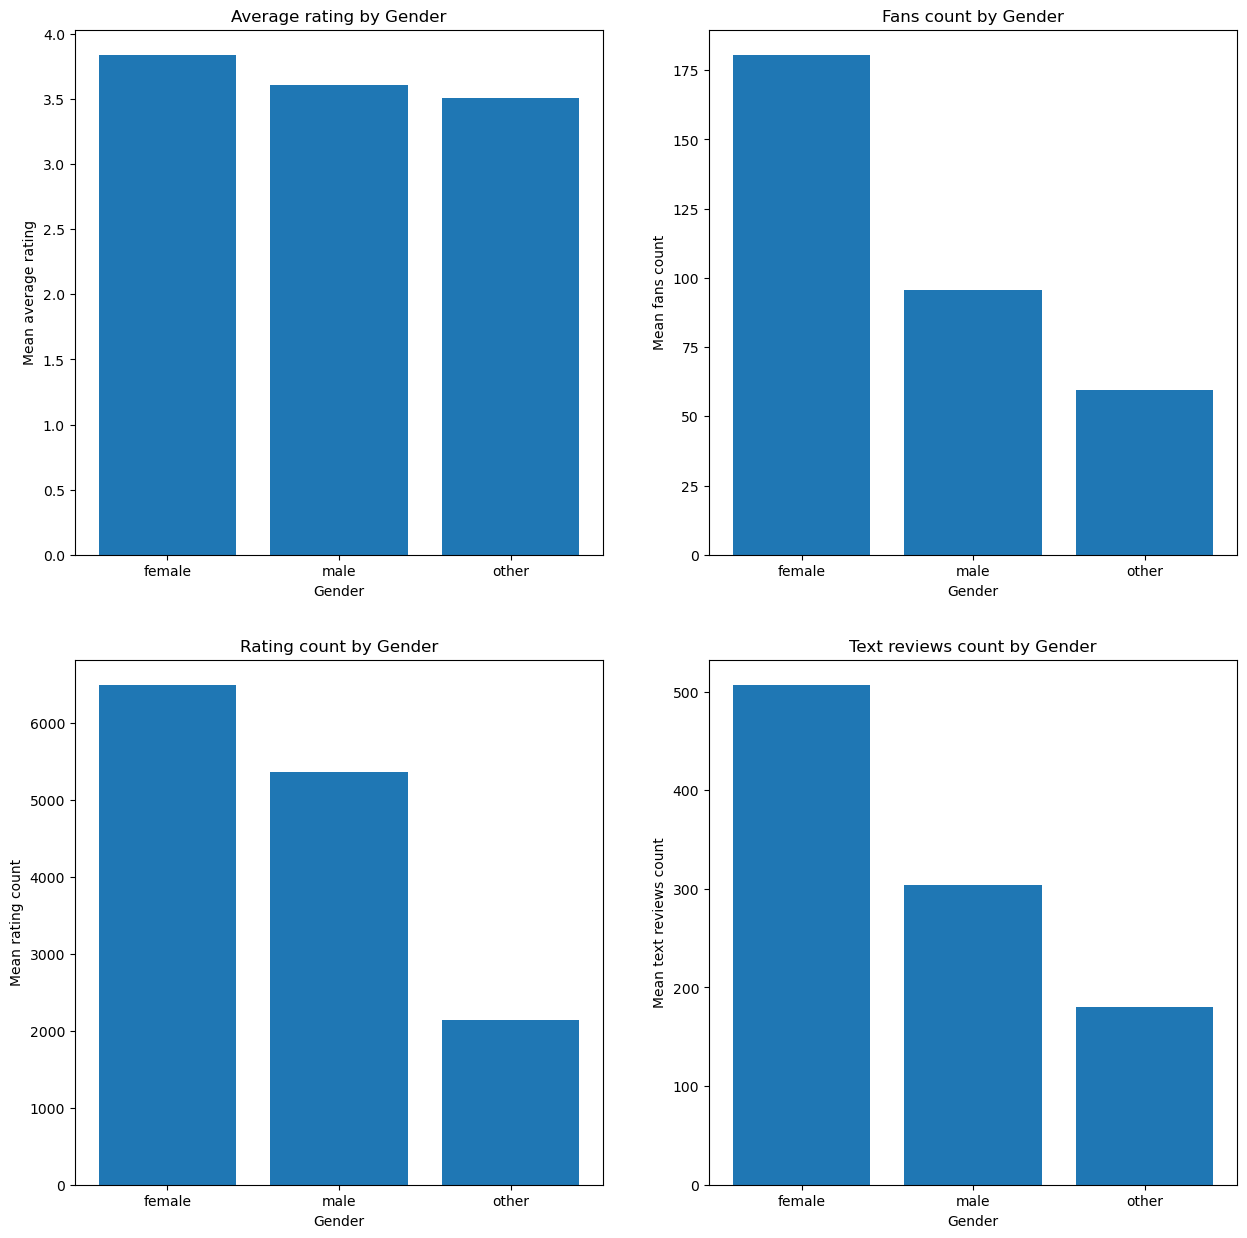

In [117]:
# transform gender values to "male," "female," or "other"
authors['gender'] = authors['gender'].str.lower().apply(
    lambda x: 'male' if x == 'male' else ('female' if x == 'female' else 'other'))

# group the new simpler data by gender, and get mean values
gender_grouped = authors.groupby('gender').agg({'average_rating': 'mean', 'fans_count': 'mean', 'ratings_count': 'mean', 'text_reviews_count': 'mean'}).reset_index()

# plots to visibly show any disparities
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# plot the first subplot for average ratings
ax1.bar(gender_grouped['gender'], gender_grouped['average_rating'])
ax1.set_title('Average rating by Gender')
ax1.set_xlabel('Gender')
ax1.set_ylabel('Mean average rating')

# plot the second subplot for fan counts
ax2.bar(gender_grouped['gender'], gender_grouped['fans_count'])
ax2.set_title('Fans count by Gender')
ax2.set_xlabel('Gender')
ax2.set_ylabel('Mean fans count')

# plot the second subplot for number of reviews
ax3.bar(gender_grouped['gender'], gender_grouped['ratings_count'])
ax3.set_title('Rating count by Gender')
ax3.set_xlabel('Gender')
ax3.set_ylabel('Mean rating count')

# plot the second subplot for number of reviews
ax4.bar(gender_grouped['gender'], gender_grouped['text_reviews_count'])
ax4.set_title('Text reviews count by Gender')
ax4.set_xlabel('Gender')
ax4.set_ylabel('Mean text reviews count')

plt.show()

**Analysis:**

* In terms of average rating, males, females and unassigned authors do not witness any visible disparity, all being relatively close to each other with only a slight advantage for females.
* In terms of fans count we can observe a disparity: females have a far higher fan count than both males and "other", almost double the men's and quadruple the "others".
* In terms of rating count we can observe a little disparity between females and males (toward females) and a greater disparity between them and "other".
* In terms of text reviews count we can observe a great disparity overall: females almost double males and males almost double "other".

## [RQ6] For this question, consider the top 10 authors concerning the number of fans again.

**Request 6.1:** Provide the average time gap between two subsequent publications for a series of books and those not belonging to a series. What do you expect to see, and what is the actual answer to this question?

In [130]:
df = top_authors_books.copy()
pattern = r"(-?[1-9][0-9]{3})(?:-(0[1-9]|1[0-2]))?(?:-[0-2][0-9]|3[0-1])?"
df[["year", "month"]] = df["original_publication_date"].str.extract(pattern)
df = df[(~df["year"].isna())]
df["month"] = df["month"].fillna(0).astype(int) + df["year"].astype(int) * 12
df.drop(["year"], axis = 1, inplace = True)
df.sort_values(by = "month", inplace = True)

# calculate time gap between consecutive "original" publications and add it into a column for all books
df["time_gap"] = df.groupby(["author_id", "series_id"])["month"].diff()
# remove first elem that has diff with 0
df = df[df["time_gap"] >= 0]

# calculate the average time gap for books in a series and not in a series, according to the new column created
average_time_gap_series = df[df["series_id"] != ""]["time_gap"].mean()
average_time_gap_non_series = df[df["series_id"] == ""]["time_gap"].mean()

print("Average time gap between books of a series is", round(average_time_gap_series, 4), "months.")
print("Average time gap between books of a series is", round(average_time_gap_non_series, 4), "months.")

Average time gap between books of a series is 0.4761 months.
Average time gap between books of a series is 1.7019 months.


As expected the books that belong to a series have a more periodic and regular output from the authors(on average), and this logically makes sense following the idea that the author is breaking down a full story into separate books.
Books that do not belong to a series do not have a greater average gap between them since they are independent works and do not follow any periodic output "expectation" from the public.

---

**Request 6.2:** For each of the authors, give a convenient plot showing how many books has the given author published UP TO a given year. Are these authors contemporary with each other? Can you notice a range of years where their production rate was higher?

---

We notice there is a wrong value at year 1111 and remove it.

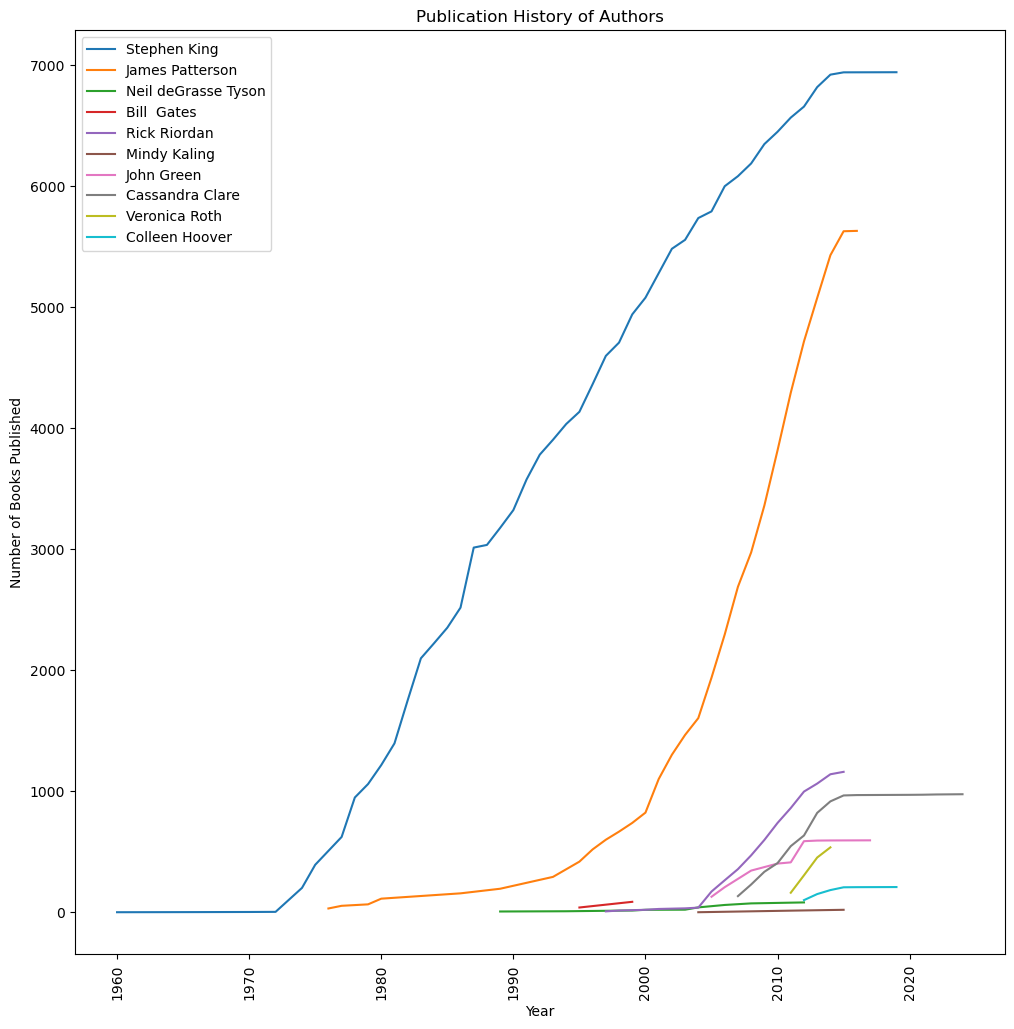

In [143]:
df = top_authors_books.copy()
pattern = r"(-?[1-9][0-9]{3})(?:-0[1-9]|1[0-2])?(?:-[0-2][0-9]|3[0-1])?"
df[["year"]] = df["original_publication_date"].str.extract(pattern)
df = df[(~df["year"].isna())]
df["year"] = df["year"].astype(int)
df = df[df["year"] > 1111]
df.sort_values(by = "year", inplace = True)

# define a new column using the datetime format of the original publication date
writers_counts = df.groupby(['author_name', 'year']).size().reset_index(name='Count')
writers_counts.sort_values(by = "year", inplace = True)

# plot the publication history for each author
writers = writers_counts['author_name'].unique()
plt.figure(figsize=(12, 12))

for writer in writers:
    author_data = writers_counts[writers_counts['author_name'] == writer]
    plt.plot(author_data['year'], author_data['Count'].cumsum(), label=writer)

plt.title("Publication History of Authors")
plt.xlabel("Year")
plt.xticks(rotation=90)
plt.ylabel("Number of Books Published")
plt.legend()
plt.show()

We notice all authors in the plot seem to have worked in the last 50 years.

## [RQ7] Estimating probabilities is a core skill for a data scientist: show us your best!

**Request 7.1:** Estimate the probability that a book has over 30% of the ratings above 4.

---

As asked by the TAs we use "above or equal 4" instead of "above 4".

In [407]:
def has_30p_above_four(rating_dist):
    pattern = r"5:([0-9]+)\|4:([0-9]+)\|3:[0-9]+\|2:[0-9]+\|1:[0-9]+\|total:([0-9]+)"

    match = re.search(pattern, rating_dist)
    if (int(match.group(1)) + int(match.group(2))) > 0.3 * int(match.group(3)):
        return True
    else:
        return False

above_four = sum(df["rating_dist"].apply(has_30p_above_four))

result = above_four / df.shape[0]
print("The probability that a book has over 30% of the ratings above or equal to 4 is", round(result, 4) * 100, "%")

The probability that a book has over 30% of the ratings above or equal to 4 is 81.69 %


**Request 7.2:** Estimate the probability that an author publishes a new book within two years from its last work.

---

Not every author on the authors dataset has a book in the books dataset, that is because our datasets are only a subset of the original one. This means that we there could be come authors that have published a new book within two years from their last work but since that book istance is not present in our dataset and we do not count it. However we could not even say that our estimate is a lower bound of the real probability because not every author is present in our dataset.

We divide by the number of books minus the number of authors to obtain the total number of "non-first books".

In [98]:
df = books
pattern = r"(-?[1-9][0-9]{3}|[1-9][0-9]{2}|[1-9][0-9]|[0-9])(?:-(0[1-9]|1[0-2]))?(?:-[0-2][0-9]|3[0-1])?"
df[["year", "month"]] = df["original_publication_date"].str.extract(pattern)
df = df[(~df["year"].isna())]
df["month"] = df["month"].fillna(0).astype(int) + df["year"].astype(int) * 12
df.drop(["year"], axis = 1, inplace = True)

grouped = df.groupby("author_id")

score = 0
for group_name, group_data in tqdm(grouped, total = grouped.ngroups):
    group_data = group_data.sort_values(by = "month")
    previous = group_data["month"].head(1).item()

    for elem in group_data["month"]:
        if elem - previous != 0 and elem - previous <= 48:
            score += 1

result = score / (df.shape[0] - df["author_id"].unique().shape[0]) # we remove the first work for each author
print("The probability that an author publishes a new book whitin two years from it's last work is: ", round(result, 4) * 100, "%")

C:\Users\Utente\AppData\Local\Temp\ipykernel_8388\368727133.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["month"] = df["month"].fillna(0).astype(int) + df["year"].astype(int) * 12
C:\Users\Utente\AppData\Local\Temp\ipykernel_8388\368727133.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(["year"], axis = 1, inplace = True)


  0%|          | 0/254010 [00:00<?, ?it/s]

The probability that an author publishes a new book whitin two years from it's last work is:  17.18 %


**Request 7.3:** In the file list.json, you will find a peculiar list named "The Worst Books of All Time." Estimate the probability of a book being included in this list, knowing it has more than 700 pages.

---

We call the "Book is in the worst books list" event $A$ and "Book has more than 700 pages" event $B$. We calculate it using the conditional probability formula:

$\mathbb{P}(A | B) = \frac{\mathbb{P}(A \cap B)}{\mathbb{P}(B)}$

In [95]:
df = books[books["num_pages"] != ""]

worst_books = pd.read_json(list_path, lines = True, nrows = 1)["books"][0]
worst_books = pd.DataFrame(worst_books)
worst_books["book_id"] = worst_books["book_id"].astype(int)
join = pd.merge(worst_books, df, left_on = "book_id", right_on = "id", how = "inner", suffixes = ["_w", "_b"])

pAB = join[join["num_pages"].astype(int) > 700].shape[0] / df[df["num_pages"] > 700].shape[0]
print("P(A | B), the probability of a book being included in the worst books list, knowing it has more than 700 pages: ", round(pAB, 6) * 100, "%")

P(A | B), the probability of a book being included in the worst books list, knowing it has more than 700 pages:  0.198 %


**Request 7.4:** Are the events X=’Being Included in The Worst Books of All Time list’ and Y=’Having more than 700 pages’ independent? Explain how you have obtained your answer.

---

To check whether the X and Y are indipendent we can apply the definition of indipendence. Two events are indipendent if knowing that one happened does not change the probability of the second one appearing. Formally speaking, that is when:

$\mathbb{P}(X \cap Y) = \mathbb{P}(X) \cdot \mathbb{P}(Y)$

To reuse the previously calculated probabilities we can also add the definition of conditional probability:

$\mathbb{P}(X | Y) = \frac{\mathbb{P}(X \cap Y)}{\mathbb{P}(Y)}$

From which we obtain that if X and Y are indipendent:

$\mathbb{P}(X | Y) = \mathbb{P}(X)$

$\mathbb{P}(Y | X) = \mathbb{P}(Y)$


We called X as A and Y as B. Then to check for indipendence we can just check whether $\mathbb{P}(\text{A | B})$ and $\mathbb{P}(\text{B | A})$ are equal respectively to $\mathbb{P}(A)$ and $\mathbb{P}(B)$. To be precise indipendence is a two-way relation, so if one holds also the second must hold, this means we really only need to check one of those two.

In [96]:
pA = join.shape[0] / df.shape[0]
pB = df[df["num_pages"].astype(int) > 700].shape[0] / (df.shape[0])
pBA = join[join["num_pages"].astype(int) > 700].shape[0] / join.shape[0]

print("Test 1:")
print("P(A), the probability of a book of the whole dataset to be in the worst books list: ", round(pA, 6) * 100, "%")
print("P(A | B), the probability of a book to be in the worst books list, knowing that it has more than 700 pages: ", round(pAB, 6) * 100, "%")

print("Test 2:")
print("P(B), the probability of book of the whole dataset to have more than 700 pages over the total: ", round(pB, 6) * 100, "%")
print("P(B | A), the probability of books to have more than 700 pages knowing that it is in the worst books list: ", round(pBA, 6) * 100, "%")

Test 1:
P(A), the probability of a book of the whole dataset to be in the worst books list:  0.145 %
P(A | B), the probability of a book to be in the worst books list, knowing that it has more than 700 pages:  0.198 %
Test 2:
P(B), the probability of book of the whole dataset to have more than 700 pages over the total:  2.8091999999999997 %
P(B | A), the probability of books to have more than 700 pages knowing that it is in the worst books list:  3.8348 %


As we can see the two events are dependent.

## [RQ8] Charts, statistical tests, and analysis methods are splendid tools to illustrate your data-driven decisions to check whether a hypothesis is correct.

**Request 8.1:** Can you demonstrate that readers usually rate the longest books as the worst?

In [144]:
df = books[books["num_pages"] != ""]
df["num_pages"] = df.num_pages.astype(int)

# we try to remove outliers
df = df[(df["num_pages"] < 1500) & (df["num_pages"] != 0) & (df["average_rating"] != 0)]

C:\Users\Utente\AppData\Local\Temp\ipykernel_8388\1800968357.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["num_pages"] = df.num_pages.astype(int)


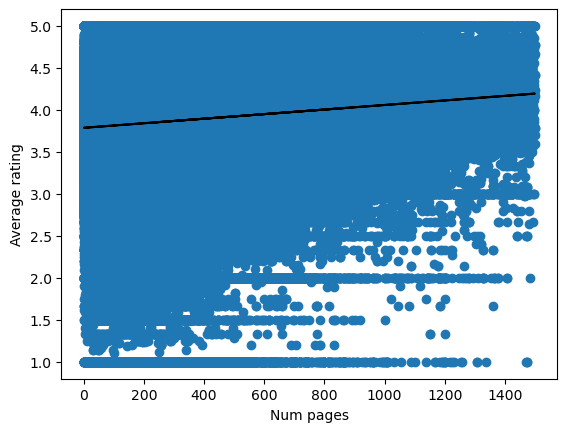

In [145]:
plt.scatter(df["num_pages"], df["average_rating"])

plt.ticklabel_format(axis = "y", style = "plain")
plt.xlabel("Num pages")
plt.ylabel("Average rating")

z = np.polyfit(df["num_pages"],  df["average_rating"], 1)
p = np.poly1d(z)
plt.plot(df["num_pages"], p(df["num_pages"]), color= "black")

plt.show()

This scatterplot is confusing, we try to use a heatmap.

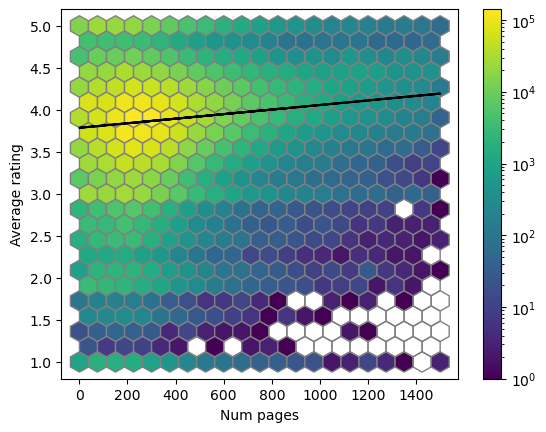

In [146]:
plt.hexbin(df["num_pages"], df["average_rating"], gridsize = 20, bins = "log", edgecolor = "gray")

z = np.polyfit(df["num_pages"],  df["average_rating"], 1)
p = np.poly1d(z)
plt.plot(df["num_pages"], p(df["num_pages"]), color= "black")

plt.xlabel("Num pages")
plt.ylabel("Average rating")
plt.colorbar()

In [147]:
correlation = df["average_rating"].corr(df["num_pages"])
print("The correlation coefficient between 'average_rating' and 'num_pages' is:", correlation)

The correlation coefficient between 'average_rating' and 'num_pages' is: 0.09790234871325924


We see the correlation coefficient is and in the positive direction, hinting at a faint positive correlation between the number of pages and the average rating. Without our data selection the correlation is even fainter but always in a positive direction. This means that we can't demonstrate that readers usually rate the longest books as the worst, instead even if the effect is very little it's the opposite.

---

**Request 8.2:** Compare the average rate distribution for English and non-English books with a proper statistical procedure. What can you conclude about those two groups?

In [149]:
#split the books into 2 groups
eng_books = languages[languages['language'] == 'eng']
non_eng_books = languages[languages['language'] != 'eng']

First of all let's check the histograms of the average ratings of each groups

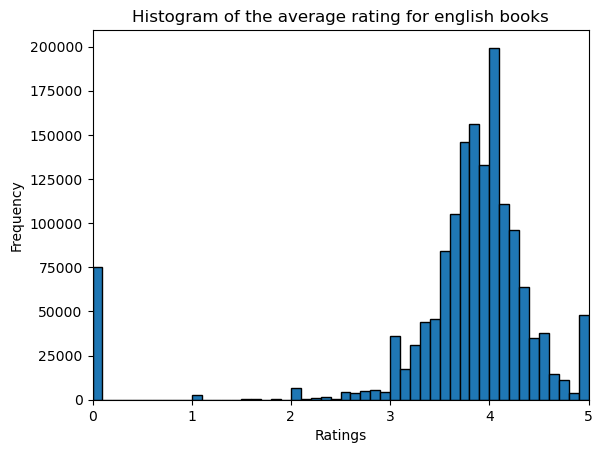

<Figure size 500x500 with 0 Axes>

In [150]:
plt.hist(eng_books.average_rating, bins=50, edgecolor='black')
plt.xlim(0,5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of the average rating for english books')
plt.figure(figsize=(5, 5))
plt.show()

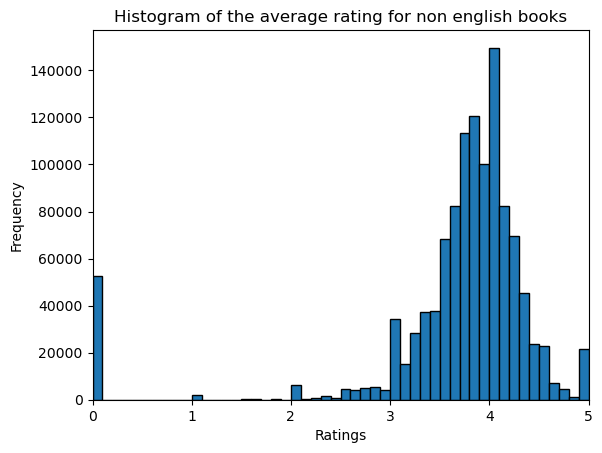

<Figure size 500x500 with 0 Axes>

In [151]:
import matplotlib.pyplot as plt 
plt.hist(non_eng_books.average_rating, bins=50, edgecolor='black')
plt.xlim(0,5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of the average rating for non english books')
plt.figure(figsize=(5, 5))
plt.show()

From the histograms it looks like there are no differences of ratings if the book is written in english or not. The two distributions are similar to a normal distribution.\
Let's see if this hypothesis is true or not doing some test.
I choose to do a t-test which is a parametric test for determining correlations between two samples of data.

So we define:\
* The null hypothesis H0 is: there no difference between the 2 groups in terms of average rating.\
* The alternative hypothesis H1 is: there is a difference between the 2 groups in terms of average rating.

We also need to choose an alpha, usually is 0.05, which means that the probability to say that they are different when they are not is not more than 5%.

In [152]:
print(np.var(eng_books.average_rating))
print(np.var(non_eng_books.average_rating))

0.9176129286165297
0.847053999124168


They have different variance so I use a Welch t-test instead of the t-test.

In [153]:
from scipy.stats import ttest_ind

alpha = 0.05
t_statistic, p_value = ttest_ind(eng_books['average_rating'], non_eng_books['average_rating'], equal_var=False)

print("p-value:", p_value)
print("t-statistic:", t_statistic)

p-value: 3.1707393770681415e-253
t-statistic: 33.99350021066016


The resulting p-value is smaller than alpha, so we reject the null hypothesis, this means that there is a significant difference between the distribution of the average rating of the two groups.

**Request 8.3:** About the two groups in the previous question, extract helpful statistics like mode, mean, median, and quartiles, explaining their role in a box plot.

In [154]:
import statistics
print(eng_books.average_rating.describe())
print("mode        ", statistics.mode(eng_books.average_rating))

count    1.531825e+06
mean     3.703881e+00
std      9.579215e-01
min      0.000000e+00
25%      3.610000e+00
50%      3.900000e+00
75%      4.130000e+00
max      5.000000e+00
Name: average_rating, dtype: float64
mode         0.0


In [155]:
print(non_eng_books.average_rating.describe())
print("mode       ", statistics.mode(non_eng_books.average_rating))

count    1.155113e+06
mean     3.664644e+00
std      9.203558e-01
min      0.000000e+00
25%      3.560000e+00
50%      3.860000e+00
75%      4.090000e+00
max      5.000000e+00
Name: average_rating, dtype: float64
mode        0.0


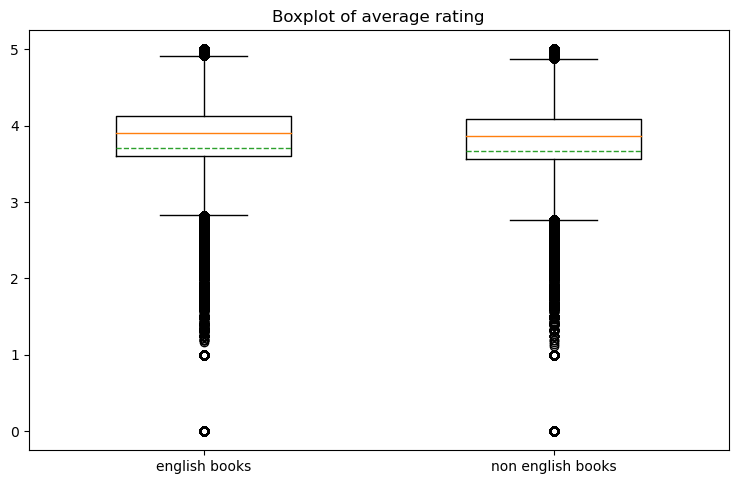

In [158]:
fig = plt.figure(figsize =(10, 7))
 
ax = fig.add_axes([0, 0, 0.7, 0.6])
libri=[eng_books.average_rating, non_eng_books.average_rating]
box = ax.boxplot(libri, widths=0.5, meanline=True, showmeans=True) 

ax.set_xticklabels(['english books','non english books'])
plt.title('Boxplot of average rating') 

plt.show()

In a boxplot the median is represented by the yellow line, and the first and third quintile are represented by the upper and lower line of the box.\
So for example: \
For the english books the median is 3.96 this means that 50% of the values are lower than 3.96 and if we see the distance of the first and third quintile from the median, we can notice that they are quite similar so this means they are simmetrical.\
The mode helps to identify around which value the distribution is centered in this case for the two groups is 4 and as we can see from the boxplots the distributions are centered in this value.\
Mean is not visible in the boxplot and for each group median and mean are softly different.

---

**Request 8.4:** It seems reasonable to assume that authors with more fans should have more reviews, but maybe their fans are a bit lazy. Confirm or reject this with a convenient statistical test or a predictive model.

---

We provide two approaches to this request:

**Approach 1:**

In [171]:
df = authors[authors["fans_count"] != 0]

The assumption is that fans of popular authors are more "lazy" and leave less reviews. We can check if there is a correlation between the numbers of fans and number of reviews.

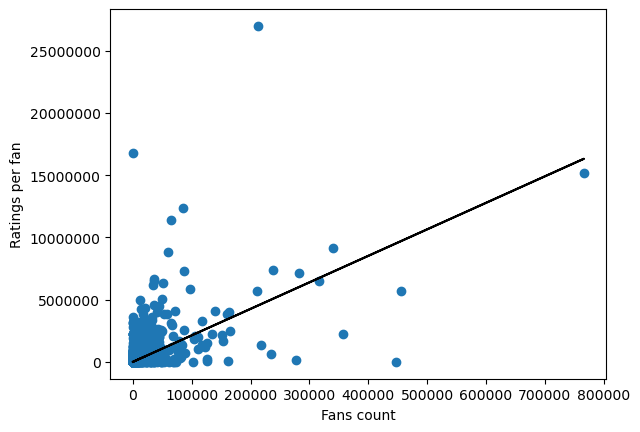

In [172]:
plt.scatter(df["fans_count"], df["ratings_count"])

plt.ticklabel_format(axis = "y", style = "plain")
plt.xlabel("Fans count")
plt.ylabel("Ratings per fan")

z = np.polyfit(df["fans_count"],  df["ratings_count"], 1)
p = np.poly1d(z)
plt.plot(df["fans_count"], p(df["fans_count"]), color= "black")

plt.show()

There is a correlation between the two. However a more precise measure would be to check for every author it's factor of "review per fan", that better shows the fact that fans of great authors are more lazy or not.

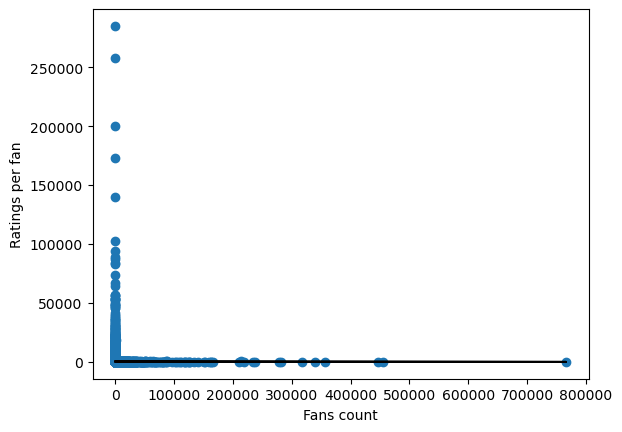

In [174]:
plt.scatter(df["fans_count"], df["ratings_count"] / df["fans_count"])

plt.ticklabel_format(axis = "y", style = "plain")
plt.xlabel("Fans count")
plt.ylabel("Ratings per fan")

z = np.polyfit(df["fans_count"],  df["ratings_count"] / df["fans_count"], 1)
p = np.poly1d(z)
plt.plot(df["fans_count"], p(df["fans_count"]), color= "black")

plt.show()

Outliers render the scatterplot difficult to read. Let's see something about this strange values.

In [175]:
outlier = df[(df["ratings_count"] / df["fans_count"]) == (df["ratings_count"] / df["fans_count"]).max()]
outlier

,ratings_count,average_rating,text_reviews_count,book_ids,name,gender,fans_count,books_count,author_id
id,,,,,,,,,
569383,3136361,3.8,38475,"[18135, 5213540, 5213500, 1622, 2989631, 12957...",Barbara A. Mowat,female,11,57,569383


In the provided book dataset there is no information about what book this author wrote, but searching online we can see she is written as the editor of some of the most important Shakespeare plays, like Romeo and Juliet. This means that the column "rating_count" counts not only those books for which the person is the main author but everything that author has worked on. This also explains why she has a very high ratings count while having a very low fan count.

We can try to remove this kind of authors from our dataset by setting a minimum threshold for "fan_count".

In [176]:
df = authors[authors["fans_count"] > 2500]

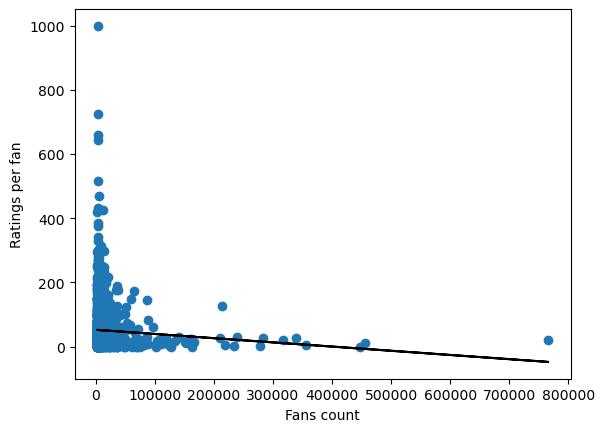

In [177]:
plt.scatter(df["fans_count"], df["ratings_count"] / df["fans_count"])

plt.ticklabel_format(axis = "y", style = "plain")
plt.xlabel("Fans count")
plt.ylabel("Ratings per fan")

z = np.polyfit(df["fans_count"],  df["ratings_count"] / df["fans_count"], 1)
p = np.poly1d(z)
plt.plot(df["fans_count"], p(df["fans_count"]), color= "black")

plt.show()

And as before we also plot a heatmap to better understand the distribution:

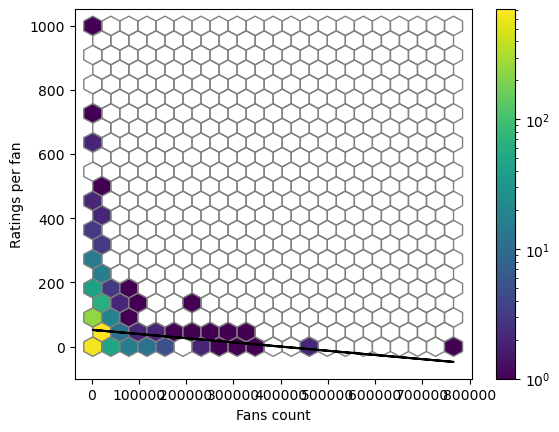

In [178]:
plt.hexbin(df["fans_count"], df["ratings_count"] / df["fans_count"], gridsize = 20, bins = "log", edgecolor = "gray")

z = np.polyfit(df["fans_count"],  df["ratings_count"] / df["fans_count"], 1)
p = np.poly1d(z)
plt.plot(df["fans_count"], p(df["fans_count"]), color= "black")

plt.xlabel("Fans count")
plt.ylabel("Ratings per fan")
plt.colorbar()

In the end we can say that the assumption made was correct, but the correlation is not very strong.

**Approach 2:**

We decide to do a linear regression model.

In [159]:
from sklearn.linear_model import LinearRegression

x = authors[['fans_count']] #independent variable
y = authors['ratings_count'] #dependent variable

model_1 = LinearRegression()
model_1.fit(x, y)

# Print the coefficients
print(f"Intercept: {model_1.intercept_}")
print(f"Coefficient: {model_1.coef_[0]}")

Intercept: 2391.7391920170053
Coefficient: 21.314398923418658


The intercept $\alpha$ is equal to 2392 ca. this means that if an author has not any fans, so $x=0$, the author still has 2391 ratings, this is why this situation is called the baseline.\
The coefficient $\beta$ is equal to 21.3 so, on average,if there is an increment of 1 fan, the ratings count increase about of 21 ratings. But we cannot still conclude about the laziness of the fans.

In [160]:
from sklearn.linear_model import LinearRegression

x = authors[['fans_count']] #independent variable
y = authors['text_reviews_count'] #dependent variable

model_2 = LinearRegression()
model_2.fit(x, y)

# Print the coefficients
print(f"Intercept: {model_2.intercept_}")
print(f"Coefficient: {model_2.coef_[0]}")

Intercept: 218.6739622461071
Coefficient: 1.006448295564882


The intercept $\alpha$ is equal to 219 ca. this means that if an author has not any fans, so $x=0$, the author still has 219 reviews.\
The coefficient $\beta$ is equal to 1 so, on average,if there is an increment of 1 fan, the text_reviews_count increase about of 1 rating.\
With these considerations, knowing that the ratings are stars while the text review ratings are to be written, we can conclude that fans are quite lazy because as we can see in the model_2 the text rating increase less than just rating.

---

**Request 8.5:** Provide a short survey about helpful statistical tests in data analysis and mining: focus on hypothesis design and the difference between parametric and nonparametric tests, explaining the reasons behind the choice of one of these two tests.

---

Parametric and nonparametric tests are two types of statistical analysis used to test hypotheses about population parameters.\
The main difference between them is that the first requires some assumptions about the probability distribution of the data. Parametric tests assume that the data follows a specific probability distribution and rely on the estimation of parameters such as means and variances to make inferences about population characteristics. When assumptions are met, parametric tests are typically more powerful than nonparametric tests; but, when assumptions are not met, they may be less reliable. So the non parametric tests use methods that do not involve parameter estimation.\
Hypothesis of the parametric tests include: the data shoud be continuous and normally distribuited and same variance between the groups we are analyzing.\
Non parametric tests don't include the hypothesis just mentioned.\
So if the hypotheses are not met we will use non parametric tests but if they are met and sample sizes are adequate we'll use the parametric one because compared to non-parametrics, they give a better and more precise solution.

# Bonus points

## 1

**Request 1.1:** Select one alternative library to Pandas (i.e., Dask, Polar, Vaex, Datatable, etc.), upload authors.json dataset, and filter authors with at least 100 reviews. Do the same using Pandas and compare performance in terms of milliseconds.

In [99]:
# TRY ON MAIN PC

# IN PANDAS

print("Measuring Pandas performance...")
%timeit authors[authors["text_reviews_count"] >= 100]

# IN DASK

authors_dask = dd.from_pandas(authors, npartitions = 1)

print("Measuring Dask performance...")
%timeit authors_dask[authors_dask["text_reviews_count"] >= 100].compute()

Measuring Pandas performance...
24.4 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Measuring Dask performance...
25.6 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Dask is a library very similar to Pandas but specialized to work on bigger datasets. It's greatest characteristic is intended parallel computing, intended both as local, where different cores of the same CPU are used at the same time, and cloud, where the computation is divided between computers clusters. Another important difference is it's "lazy evalutaion", operations are not executed when requested in the code but instead they are delayed and really executed only when explicitly told so or when necessart (Ex. if we request to plot the data it's necessary for the computation to be done).

We can't observe a meaningful difference between the two operations, we think it's because of the small size of the dataset.

---

**Request 1.2:** Select one alternative library to Pandas (i.e., Dask, Polar, Vaex, Datatable, etc.), upload books.json, and join them with authors.json based on author_id. How many books don’t have a match for the author?

In [105]:
authors["author_id"] = authors.index # add back id column

join = dd.merge(dd.from_pandas(books, npartitions = 1), dd.from_pandas(authors, npartitions = 1), left_on = "author_id", right_on = "id", how = "left")
authorless_instances = join["author_id_y"].isna().compute().sum()
print("Authorless instances: ", authorless_instances)

Authorless instances:  107


## 2 Every book should have a field named description, and any author should have a field named description. Choose one of the two and perform a text-mining analysis:

To perform the text-mining analysis we created a list of tag words for specific literary genres that should help us identify books and and authors. List can have words in common as same concepts can appear in different genres (as "monster" can appear both in horror and fantasy genres) or when the same word is used with different meanings (as "chemistry" can appear both in romance and scientific books). Some words have spaces before and after to avoid finding it inside other words (as "art" in "artificial") or only before when we want to find also composed word (as for "dread" and "dreadful").

We decided to use the same method for both books and authors.

In [5]:
comedy_tags = ["humor", "comedy", "satire", "funny", "laugh", "comical", "hilarious", "laughter", "light-hearted", "parody", "joke", "amusing", "whimsical", "lighthearted", "satirical", "witty", "silly", "absurd", "hilarity", "comedic", "farce", "irony", "sarcasm", "slapstick"]
action_tags = ["action", "adventure", "suspense", "thriller", "bravery", "excitement", "adrenaline", "tension", "intense", "escape", "dangerous", "fast-paced", "adversary", "hero", "spy", "villain", "combat", "fight", "chase", "explosion", "fighting", "danger", "martial art", "high-octane", "adrenaline", "rescue", "mission", "conspiracy", "intelligence", "agent", "secret"]
fantasy_tags = ["fantasy", "magic", "wizardry", "dragon", "god", "elf", "dwarf", "monster", "sword", "quest", "castle", "mythical", "prophecy", "fairy", "sorcery", "sorcerer", "witchcraft", "enchantment", "magician", "spellcasting", "conjuring", "curse", "alchemy", "mysticism", "occult", "supernatural", "sorcerer", "witch", "spell", "ritual", "arcane", "knowledge", "magical", "wizard"]
romance_tags = ["romance", "love ", "relationship", "passion", "heartfelt", "heart", "attraction", "emotional", "romantic", "couple", "affection", "intimacy", "sweetheart", "desire", "chemistry", "flirting", "courtship", "kiss", "embrace", "lover", "seduction", "infatuation", "lovesick"]
mystery_tags = ["mystery", "detective", "suspense", "crime", "secrets", "clue", "mysterious", "victim", "suspicious", "suspicion", "death", "poison", "intrigue", "theft", "thief", "whodunit", "widow", "missing", "killer", "unsolved", "assassin", "twists", "investigation", "thriller", "clues", "sleuth", "police", "intrigue", "enigma", "puzzle", "murder", "conspiracy", "forensic", "stabbed", "solving", "sleuthing", "suspicion", "unraveling", "evidence", "schemes", "riddle", "murder", "revenge", "blackmail", "investigate"]
sci_fi_tags = ["sci-fi", "planet", "science fiction", "space", "technology", "extraterrestrial", "future", "dystopian", "cyberpunk", "aliens", "time travel", "robots", "intergalactic", "virtual reality", "apocalypse", "AI", "nanotechnology", "post-apocalyptic"]
historical_tags = ["historical", "history", "period", "accuracy", "context", " era ", "research", "centuries", "century", "europe", "america", "asia", "africa"]
horror_tags = ["horror", "scary", "terror", "fear", "creepy", " dread", "spooky", "haunting", "macabre", "dark", "nightmare", "ghost", "possessed", "demon", "paranormal", "frightening", "sinister", "psychological", "halloween", "chill", "gore", "haunted"]
science_tags = ["science", "scientist", "research", "engineering", "discovery", "innovation", "technology", "scientific method", "experiment", "data", "analysis", "laboratory", "biology", "physic", "chemistry", "astronomy", "environment", "ecology", "genetic", "geology", "cosmology", "neuroscience"]
philosophy_tags = ["philosophy", "philosopher", "ethic", "morality", "metaphysic", "epistemology", "logic", "existentialism", "ontology", "aesthetic", "truth", "knowledge", "consciousness", "free will", "rationalism", "skepticism", "nihilism", "stoicism", "existentialism", "idealism", "trascendence"]
how_to_tags = ["how-to", "guide", "tutorial", "instruction", "step-by-step", "self-help", "manual", "handbook", "tips", "advice", "techniques", "DIY", "lessons", "methods", "strategies", "procedures", "skills", "training", "tactics", "expertise"]
spirituality_tags = ["spirituality", "mindfulness", "meditation", "spiritual", "enlightenment", "inner peace", "consciousness", "self-discovery", "yoga", "soul", "journey", "wisdom", "meditative", "yoga", "peaceful", "serenity", "inspiration"]
religion_tags = ["religion", "faith", "atheism", "belief", "theology", "god", "religious", "monotheism", "polytheism", "scripture", "worship", "prayer", "religious text", "religious practices", "theological debate", "interfaith", "sacred", "ritual", "divinity", "pope", "bible"]
cook_tags = ["cooking", "culinary", "recipes", "cookbook", "gastronomy", "food", "culinary art", "chef", "cuisine", "kitchen", "techniqus", "baking", "gourmet", "foodie", "tasty", "cultural cuisine", "food science", "culinary history", "meal", "cooking tips"]
classic_tags = ["classic", "vintage", "nostalgic", "ageless", "traditional", "heritage", "historic", "canonical", "antique", "retro", "enduring", "beloved", "history", "mythology", "culture", "grek", "roman", " art ", "archaeology", "empire"]
economy_tags = ["economy", "economic", "growth", "money",  "bank", "capital", "entrepreneur", "management", "global", "industry", "policy", "finance", "business", "trend", "market", "investment", "wealth", "fiscal", "monetary", "budgeting", "capitalism", "consumer", "taxation", "entrepreneurship", "financial", "trade", "crisis", "marketplace", "regulation", "inflation", "deflation", "supply", "demand", "globalization", "competition", "budget", "risk", "income"]

We decided to use two parameters that set the number of tags to take per book and per author.

In [6]:
def calculate_tag_scores(description):
    description_lower = description.lower()
    scores = [sum(description_lower.count(word) for word in tag_list) for tag_list in tags_lists]
    return pd.Series(scores, index = tag_names)

tags_lists = [comedy_tags, fantasy_tags, action_tags, romance_tags, mystery_tags, sci_fi_tags, historical_tags, horror_tags, science_tags, philosophy_tags, how_to_tags, spirituality_tags, religion_tags, cook_tags, classic_tags, economy_tags]
tag_names = [tag_list[0] for tag_list in tags_lists]

n_tags_per_book = 3
n_tags_per_author = 3

**Request 2.1:** If you choose to text-mine books.json ’ descriptions, try to find a way to group books in genres using whatever procedure you want, highlighting words that are triggers for these choices.

In [7]:
# load books dataset
# before we ignored the description column, now we take it together with 'id', 'author_id' and 'title'

books_descriptions = pd.DataFrame()

chunks_number = np.ceil(7027431 / chunk_size)
chunks = pd.read_json("datasets/lighter_books.json", lines = True, chunksize = chunk_size)

for chunk in tqdm(chunks, total = chunks_number):
    chunk = chunk[["id", "author_id", "title", "description"]]
    books_descriptions = pd.concat([books_descriptions, chunk])

  0%|          | 0/71.0 [00:00<?, ?it/s]

In [8]:
tqdm.pandas()
books_tags_scores = books_descriptions["description"].progress_apply(calculate_tag_scores)

books_tags_dataset = books_descriptions[["id", "author_id", "title"]]
books_tags_dataset["tag"] = books_tags_scores.progress_apply(lambda x: x.nlargest(n_tags_per_book).index.tolist(), axis=1).values.tolist()

books_tags_dataset.set_index("id", inplace = True)
books_tags_dataset

  0%|          | 0/7027431 [00:00<?, ?it/s]

  0%|          | 0/7027431 [00:00<?, ?it/s]

,author_id,title,tag
id,,,
2,1077326,Harry Potter and the Order of the Phoenix (Har...,"[horror, fantasy, mystery]"
3,1077326,Harry Potter and the Sorcerer's Stone (Harry P...,"[fantasy, action, romance]"
4,1077326,Harry Potter and the Chamber of Secrets (Harry...,"[fantasy, mystery, horror]"
5,1077326,Harry Potter and the Prisoner of Azkaban (Harr...,"[fantasy, mystery, horror]"
6,1077326,Harry Potter and the Goblet of Fire (Harry Pot...,"[fantasy, mystery, how-to]"
...,...,...,...
25521013,7994,Julie eller Den nya Héloïse BOK I,"[classic, fantasy, romance]"
25521014,3510823,A Frozen Heart,"[romance, humor, fantasy]"
25521015,5614141,O Segredo Da Serpente,"[mystery, humor, fantasy]"


**Request 2.2:** If you choose to text-mine authors.json’ about-field, try to find a way to group authors in genres using whatever procedure you want, highlighting words that are triggers for these choices.

In [9]:
# load authors dataset
# before we ignored the about column, now we take it together with 'id' and 'name'

authors_descriptions = pd.read_json(authors_path, lines = True)
authors_descriptions = authors_descriptions[["id", "name", "about"]]

In [10]:
authors_tags_scores = authors_descriptions["about"].progress_apply(calculate_tag_scores)

authors_tags_dataset = authors_descriptions[["id", "name"]]
authors_tags_dataset["tag"] = authors_tags_scores.progress_apply(lambda x: x.nlargest(n_tags_per_author).index.tolist(), axis=1).values.tolist()

authors_tags_dataset.set_index("id", inplace = True)
authors_tags_dataset

  0%|          | 0/351767 [00:00<?, ?it/s]

  0%|          | 0/351767 [00:00<?, ?it/s]

,name,tag
id,,
4,Douglas Adams,"[science, how-to, sci-fi]"
7,Bill Bryson,"[historical, science, classic]"
10,Jude Fisher,"[fantasy, sci-fi, science]"
12,James Hamilton-Paterson,"[fantasy, historical, humor]"
14,Mark Watson,"[humor, fantasy, action]"
...,...,...
16777034,Lyon Gamer,"[humor, fantasy, action]"
16777055,Brian Hatch,"[humor, fantasy, action]"
16777067,Nicholas Baer,"[philosophy, action, historical]"


**Request 2.3:** If you feel comfortable and did both tasks, analyze the matching of the two procedures. You grouped books and authors in genres. Do these two procedures show correspondence?

---

We join the two datasets and search how often the book tag and the author tag correspond. We want to highlight that missing correspondences do not necessarly mean wrong predictions, as an author can be primarly focussed on a certain genre but could also have written different kinds of genres.

Before we decided the number of tags to take per book and per author. We say that in general a correspondence is correct is at least one of the tags of the book is in the list of tags of the author. We setted the two parameters with a value of three, but in the next section we also discute about the results with different parameters.

In [13]:
merged = pd.merge(books_tags_dataset, authors_tags_dataset, right_on = "id", left_on = "author_id", suffixes=('_book', '_author'))
correspondence_percentage = merged.apply(lambda row: any(tag in row['tag_author'] for tag in row['tag_book']), axis=1).sum() / books_tags_dataset.shape[0]
print("The correspondence percentage for parameters (3, 3) is:", round(correspondence_percentage, 4) * 100, "%")

The correspondence percentage for parameters (3, 3) is: 83.8 %


Using 3 for both parameters makes us obtain a correspondence ratio of 84%, that means that 84% of the times one of the three higher scored tags of the book is between the three higher scored that of the author of that book. We also tried with different kinds of parameters. 3 for books and 1 for author give us a correspondence ratio of 46% while setting both parameters to 1 give us a value of 25%. In all cases the algorithm shows it's potential, given that the accuracy at chance level is 100 / 16 = 6.25%

Without further analysis we can't really understand if that percentage is given by a misclassification of books, authors or it's just a natural effect of the fact that authors can write different genres of books.

# Command Line Question (CLQ)

Using the command line is a feature that Data Scientists must master. It is relevant since the operations there require less memory to use in comparison to other interfaces. It also uses less CPU processing time than other interfaces. In addition, it can be faster and more efficient and handle repetitive tasks quickly.

Note: To answer the question in this section, you must strictly use command line tools. We will reject any other method of response.

Looking through the files, you can find series.json, which contains a list of book series. In each series's 'works' field, you'll find a list of books that are part of that series. Report the title of the top 5 series with the highest total 'books_count' among all of their associated books using command line tools.

1. Write a script to provide this report. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_original.[put_the_proper extension]

2. Try interacting with ChatGPT or any other LLM chatbot tool to implement a more robust script implementation. Your final script should be at most three lines. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_LLM.[put_the_proper_ extension]. Add in your homework how you employed the LLM chatbot tools, validate if it is correct, and explain how you check its correctness.

The expected result is as follows:

| id    | title                                | total_books_count |
|-------|--------------------------------------|-------------------|
| 302380| Extraordinary Voyages                | 20138             |
| 94209 | Alice's Adventures in Wonderland     | 14280             |
| 311348| Kolekcja Arcydzieł Literatury Światowe| 13774             |
| 41459 | Oz                                   | 11519             |
| 51138 | Hercule Poirot                       | 11305             |

**Request 1:** Write a script to provide this report. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_original.[put_the_proper extension]

---

The shell script file *commandline_original.sh* is implemented as requested and the output correspond to what it's expected, the only difference we find it's the transformation of special characters like 'Ś' in 'Światowe' to their UNICODE counterpart, as '\u015'. Comment on the code is inside the file itself but we briefly describe how it works here:

For each line of the json file we extract 'id' and 'title' of the series and than the whole "works" subsection using Regexes. From the "works" subsection we search every field 'work_counts', sum their value, store it in an accumulator and append everything in a list. After having gone through every line of the json file we sort the list using only the total work counts field and using a for cycle print the first five results following the format of the table shown.

![](./commandline_image.png)

---

**Request 2:** Try interacting with ChatGPT or any other LLM chatbot tool to implement a more robust script implementation. Your final script should be at most three lines. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_LLM.[put_the_proper_ extension]. Add in your homework how you employed the LLM chatbot tools, validate if it is correct, and explain how you check its correctness.

---

We tried to use ChatGPT 3.5 to implement a more robust script implementation that is also at most three lines. This is the prompt sent:

```
You have to write a more robust implementation of the given bash code. Your implementation must be at most three lines long. You can't use jq.
[original sh code here]
```

We explicitely said not to use jq to avoid using external libraries. The result is stored in *commandline_LLM.sh* and it doesn't work. We can immediately see it from the different output and the fact that in the source code it's never mentioned the field "books_count". We also tried to use alternative LLMs chatbots like Bing with similar results. Similar results are obtained removing the costraint of not using the exernal library jq. If we remove the costraint of using only three lines the results become correct but also extremely similar to the original code. Meanwhile giving only the text of the question does not bring positive results.

# AWS Question (AWSQ)

AWS offers access to many cloud-based tools and services that simplify data processing, storage, and analysis. Thanks to AWS's scalable and affordable solutions, data scientists can work effectively with large datasets and carry out advanced analytics. A data scientist must, therefore, perform the essential task of learning how to use AWS. To complete a straightforward data analysis task in this question, you must set up an environment on Amazon Web Services.

In this question, you are asked to provide the most commonly used tags for book lists. Going through the list.json file, you'll notice that each list has a list of tags attached, and we want to see what are the most popular tags across all of the lists. Please report the top 5 most frequently used tags and the number of times they appear in the lists.

You have to follow the following (recommended) steps:

* Download the list.json file to your local system.
* Write a Python script that generates the report and the system's time to generate it.
* Set up an EC2 instance on your AWS account and upload the list.json file together with your script to the instance
* Compare the running times of your script on your local system and the EC2 instances.

**Important note:** Please run the same script on both your local system and your EC2 instance to compare the results. e.g., * keep the parameters the same if you are processing the data by loading it partially and aggregating the results. Comment about the differences you find.

Please provide a report as follows:

* The information about the config of the EC2 instance
* The command used to connect to the EC2
* The commands used to upload the files and run the script on the EC2 instance through your local system
* A table containing the most popular tags and their number of usage
* A table containing the running time of the script on your local system and EC2 instance

The following is the expected outcome for the most popular tags:

|     Tag            |   # Usage   |
|--------------------|------------|
| romance            |     6001    |
| fiction            |     5291    |
| young-adult        |     5016    |
| fantasy            |     3666    |
| science-fiction    |     2779    |

---

**Report:**

The AWSQ was run on the instance with the following configuration:
* Machine type: T3a.large (limited to this size by the plan provided)
* Role: LabRole, and access was allowed to an S3 bucket where I had previously stored the list.json file.
* RAM: 8Gb
* Operative System: Ubuntu

The personal computer I was working on (for the sake of performance comparison) has the following specifications:
* AMD Ryzen 9 6900Hs cpu
* 16 GB DDR5 ram
* Windows 11 home

The following commands were used to connect to the instance from windows powershell running in administrator mode. Please note that the directories and detailed paths have been replaced by placeholders for the sake of privacy and readibility:
1. cd <directory where the key is> (move to the directory where the key is located)
2. ssh -i <file.pem> <username@ip-address> (command to connect to instance, obtained from the "connect" -> "ssh" on the instance page)

Now we are connected to the instance, and have switched to using an Ubuntu terminal. To initialize my istance I used the following commands:
1. sudo apt update (to check for updates)
2. sudo apt upgrade (to install the updates)
3. sudo apt install awscli (in order to be to access the contents of my S3 bucket)

Note that I already had python3, pip and the libraries installed from a previous run of the instance done during one of the laboratory lectures. Then I downloaded the file from the S3 bucket to use it locally in the EC2 instance. I did that using the command:
* aws s3 cp s3://<bucketname> </home/ubuntu/data/list.json>

Then I opened a python command line session using the command:
* python3

And run the following code by pasting it into the console.

```
import pandas as pd
import numpy as np
from timeit import default_timer as timer
import json

start = timer()
# STEP ONE: Create an empty list to store data
data = []

# Define the JSON file path
json_file = "/home/ubuntu/list.json"

# Read the JSON file line by line
with open(json_file, 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Create a DataFrame from the list of data read
l_df = pd.DataFrame(data)
l_df = l_df[l_df["tags"].notna()]

all_tags = [tag for tags in l_df["tags"] for tag in tags]

tag_ser = pd.Series(all_tags)

# STEP THREE: Count the occurrences of different tags, and get the most recurring 5

tag_co = tag_ser.value_counts()
top_5 = tag_co.head(5)

# End timer and print results

end = timer()

print("The top 5 most frequent tags and their respective counts are:")
print(top_5)
print("This process took", end - start, "seconds to finish on the EC2 instance")
```

This code had minor changes when running on my personal computer:
```
json_file = r"path\on\local\device"
print(........."seconds to finish on my personal device")
```

The outcome was identical from both, being the following table:

| Genre            | Count |
|------------------|-------|
| romance          | 6001  |
| fiction          | 5291  |
| young-adult      | 5016  |
| fantasy          | 3666  |
| science-fiction  | 2779  |

The running times however were different:

* Personal Device: 29.56 seconds
* EC2 instance : 44.67 seconds


Please note as well that the process of loading the dataset was broken down into lines since the process was too intensive for the instance to handle.

# Algorithmic Question (AQ)

Assume you are working as a librarian at a public library in Rome. Some new books have arrived, and you are in charge of putting them on a shelf. Your supervisor will give you some instructions, and you will follow his. Each book has a unique ID, and your boss's instructions can be of the following types:

* L N - place the book with ID = N on the shelf to the left of the leftmost existing book
* R N - place the book with ID = N on the shelf to the right of the rightmost existing book
* ? N - Calculate the minimum number of books you must pop from the left or right to have the book with ID = N as the leftmost or rightmost book on the shelf.

You must follow your boss's instructions and report the answers to type 3 instructions to him. He guarantees that if he has a type 3 instruction for a book with a specific ID, the book has already been placed on the shelf.

Remember that once you've answered a type 3 instruction, the order of the books does not change.

**Input:**

The first line contains a single number, n, representing the number of your boss's instructions. The ith instruction the boss gives can be found at each of the following n lines.

**Output:**

Print your boss's type 3 instructions in the order they appear in the input.

**Examples:**

Input 1
```
L 75
R 20
R 30
L 11
? 75
L 12
L 15
? 20
```

Output 1
```
1
1
```

Input 2
```
R 1
L 2
L 3
L 4
? 3
R 5
R 6
L 7
L 8
? 4
L 9
R 10
R 11
L 12
L 13
? 11
? 3
```

Output 2:
```
1
2
0
6
```

**Request 1:** Implement a code to answer the problem above.

In [415]:
def algorithmic_question(input_string):
    input_list = input_string.split("\n")
    n_commands = int(input_list.pop(0))

    shelf = deque()
    output = []
    for i in range(n_commands):
        command = input_list[i].split(" ")
        if command[0] == "L":
            shelf.appendleft(command[1])
        elif command[0] == "R":
            shelf.append(command[1])
        elif command[0] == "?":
            index = shelf.index(command[1])
            result = min(index, (len(shelf) - 1) - index)
            output.append(result)

    print(*output, sep = "\n")
    return
 
input1 = "8\nL 75\nR 20\nR 30\nL 11\n? 75\nL 12\nL 15\n? 20\n"
print("Test1:")
algorithmic_question(input1)


input2 = "17\nR 1\nL 2\nL 3\nL 4\n? 3\nR 5\nR 6\nL 7\nL 8\n? 4\nL 9\nR 10\nR 11\nL 12\nL 13\n? 11\n? 3\n"
print("\nTest2:")
algorithmic_question(input2)

Test1:
1
1

Test2:
1
2
0
6


We implemented the requested algorithm and tested it on the two examples shown. In particular we decided to use a deque as data structure to memorize our values to grant appends to the edges of the list with O(1) time. 

---

**Request 2:** Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Do you believe this is correct? How can you double-check it? Elaborate about your answer.

---

We asked Chat GPT 3.5 for the code's time complexity using the following prompt:

```
You are given a python code for a function and asked to find its time complexity in the Big-O notation. The input for the function is a string where the first line contains a single number representing the number of instructions. The i-th instruction can be found at each of the following n lines.

[python function presented above]
```
\
The answer provided is:

```
To determine the time complexity of the given `algorithmic_question` function in Big-O notation, we need to analyze the time complexity of each part of the code separately and then combine them.

1. Splitting the input string: 
   `input_list = input_string.split("\n")`
   This operation splits the input string into a list of lines, which takes O(n) time, where n is the number of characters in the input string.

2. Extracting the number of commands:
   `n_commands = int(input_list.pop(0))`
   `pop(0)` operation on a list has a time complexity of O(n), where n is the number of elements in the list.

3. Loop over n_commands (for loop):
   The loop iterates n_commands times, and for each iteration, the following operations are performed:
   
   a. Splitting the command:
      `command = input_list[i].split(" ")`
      Splitting a string into a list has a time complexity of O(m), where m is the number of characters in the string.

   b. Checking the command type (if-elif statements):
      This is a constant-time operation as it involves simple string comparisons.

   c. Performing actions based on the command:
      - In the case of "L" and "R" commands, the list `shelf` is modified by adding or removing an element. Appending or inserting an element into a list takes O(1) time on average.
      - In the case of the "?" command, it searches for an item in the list using the `index` method. In the worst case, this can take O(n) time if the item is at the end of the list.
      - Appending to the `output` list takes O(1) time.

4. Printing the output:
   `print(*output, sep = "\n")`
   Printing the output takes O(m) time, where m is the total number of characters in the output.

In the worst-case scenario, the most time-consuming operation is searching for an item in the `shelf` list using the `index` method, which has a time complexity of O(n). Therefore, the overall time complexity of the function can be approximated as O(n_commands * n), where n_commands is the number of commands, and n is the maximum number of elements in the `shelf` list during the execution of the function.

So, in Big-O notation, the time complexity of the `algorithmic_question` function is O(n * n_commands), where n is the maximum number of elements in the `shelf` list, and n_commands is the number of commands.
```

\
Chat GPT answers explaining the steps of its reasoning and concluding that the time complexity is O(n * n_commands). Even if that is correct, Chat GPT hasn't grasped that n = n_commands, so we try the same prompt adding a line that makes it more explicit:

```
You are given a python code for a function and asked to find its time complexity in the Big-O notation. The input for the function is a string where the first line contains a single number representing the number of instructions. The i-th instruction can be found at each of the following n lines. This means that n_commands and n are the same number.

[python function presented above]
```
\
This time the answer of Chat GPT is:

```
To find the time complexity of the algorithmic_question function in Big-O notation, let's analyze the key operations within the function and count the number of times each operation is executed. We'll break it down step by step:

Splitting the input string:

The input_string.split("\n") operation takes O(n) time, where n is the number of lines in the input string.
Parsing the number of instructions:

Converting the first element of input_list to an integer (int(input_list.pop(0))) takes O(1) time.
Looping through the instructions:

The loop runs for n_commands iterations, where n_commands is the number of instructions. This loop has a time complexity of O(n_commands).
Inside the loop:

Splitting the current command: command = input_list[i].split(" "). This operation takes O(1) time since the number of words in a command is constant.

Checking the command type with if statements: These are O(1) operations since they involve simple string comparisons.

Appending to or prepending to the shelf list: These operations involve list manipulation and have a time complexity of O(k), where k is the number of elements in the list. In the worst case, k can be n (number of instructions).

Searching for an element in the shelf list: The shelf.index(command[1]) operation takes O(k) time in the worst case, where k is the number of elements in the list.

Appending to the output list: This is an O(1) operation.

Printing the output list:

The print(*output, sep="\n") operation takes O(k) time, where k is the number of elements in the output list.
Now, let's consider the overall time complexity:

The most significant part of the time complexity is the loop that runs for n_commands iterations.
Within each iteration of the loop, there are O(k) operations, where k is the maximum number of elements in the shelf and output lists.
Therefore, the overall time complexity of the algorithmic_question function can be expressed as O(n_commands * k), where n_commands is the number of instructions and k is the maximum number of elements in the shelf and output lists. In the worst case, k can be n (number of instructions), so the time complexity is O(n_commands * n), or simply O(n^2), where n is the number of instructions.

So, the time complexity of this function is O(n^2).
```

\
We belive this is correct and we can double-checking it by doing the calculations ourselves. Given that the deque grants us a O(1) insertion cost on both ends the dominant operation of the algorithm is: "`index = shelf.index(command[1])`". This line search the index corresponding to a certain element in a python deque and for doing so it has to check element by element if the object in the deque is the current one. The worst-case scenario for this operation is when the element is found as the last checked element, making the operation runs at O(m) time with m length of the deque.

This operation is inside a loop that runs n times, with n the number of operations in the input. We can imagine the worst-case scenario as n/2 "L" or "R" insertion operations and then n/2 "?" search operations, that means that both kinds of operations are called O(n) times. The worst case scenario is if we first insert all the O(n) elements and then do all the O(n) search operations, resulting in a total time complexity of O(n^2).

Another way to check whether the cost proposed is true is empirically by testing the algorithm on increasingly bigger inputs and plot its execution time, searching for the corresponding curve.

---

**Request 3:** Is the algorithm proposed in (1.) the optimal one to produce the required output? If not, can you suggest a better algorithm to perform the same task?

---

The algorithm proposed is optimal in the worst case scenario, but other implementations that uses probabilistic elements may have better average case costs. For example a dictionary has worst case scenario cost for both Get and Set operations of O(n), but thanks to the use of hash tables the average cost is only O(1).

We can imagine another algorithm that memorize every inserted element in a dictionary that has ID as key. We don't use indices but instead we say that the first element has value 0 and then we count down when we append to the left (-1, -2) and count up when we append to the right (+1, +2). For doing that we memorize "min" and "max" values and update them during insertion. When we do a search operation we just return `min((value - min), (max - value))`. This algorithm has an average cost of only O(n), as both insert and search operations are O(1).

Other alternatives may be binary search trees, but as dictionaries they also only garantee a better "average case" cost.